In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from skbio.diversity import alpha_diversity, beta_diversity
from scipy.spatial.distance import squareform
from skbio.stats.ordination import pcoa
import math
from scipy.stats import f_oneway

## Figure 1A - Genus alpha diversity Ave vs Ref

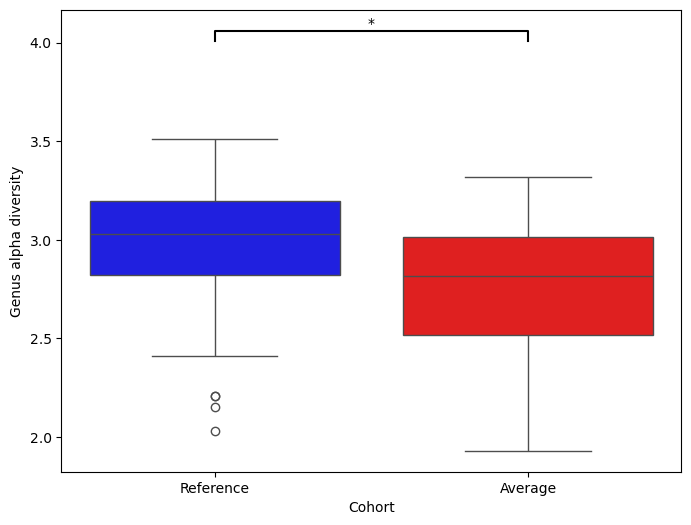

In [7]:
#Import datasets
rewell = pd.read_csv('resource/mxmarkers_rewell_con_enfermedad.csv')
reference = pd.read_csv('resource/mxmarkers_reference.csv')
df_reference = reference[['divalfa']].copy()
df_reference['source'] = 'Reference'  
df_rewell = rewell[['divalfa']].copy()
df_rewell['source'] = 'Average'

# Function to save the plot
def save_figure_as_png(fig, filename, dpi=300):
    """
    Save the current figure as a PNG file.

    Args:
        fig (matplotlib.figure.Figure): The figure to save.
        filename (str): The name of the file (without extension).
        dpi (int): Dots per inch for resolution.
    """
    fig.savefig(f"{filename}.png", format='png', dpi=dpi, bbox_inches='tight')

# Significance annotation
def add_significance_line(ax, group1, group2, y_position, p_value):
    """Adds a significance line and annotation between two groups."""
    x1, x2 = group1, group2
    y, h, col = y_position, 0.05, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    significance = "ns" if p_value > 0.05 else ("*" if p_value <= 0.05 else ("**" if p_value <= 0.01 else ("***" if p_value <= 0.001 else "****")))
    ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col)

# t-test
t_stat, p_value = ttest_ind(rewell['divalfa'], reference['divalfa'], equal_var=False)

# Concat dataframes
df_combined_rew_ref = pd.concat([df_reference[['divalfa', 'source']], df_rewell[['divalfa', 'source']]])

# Color definition
custom_palette = {'Reference': 'blue', 'Average': 'red'}

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_combined_rew_ref, x='source', y='divalfa', palette=custom_palette, hue='source', ax=ax)

# Add significance line
y_position = df_combined_rew_ref['divalfa'].max() + 0.5
add_significance_line(ax, 0, 1, y_position, p_value)

# Title and labels
ax.set_ylabel('Genus alpha diversity')
ax.set_xlabel('Cohort')

# Save the figure
save_figure_as_png(fig, "fig_1a", dpi=300)

# Show the plot
plt.show()


## Fig 1B-D - Cazymes families and subfamilies diversity

C:\Users\milagros.trotta\AppData\Local\anaconda3\envs\cazymes\Lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.055392127143252236 whereas the largest positive one is 2.5142377628013173.
  warn(


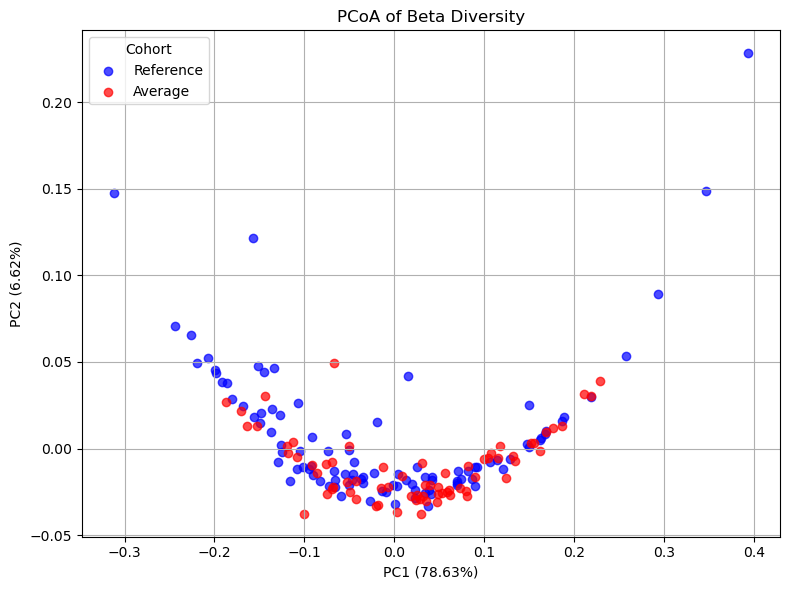

In [12]:
# Load data for both groups
file_paths = {
    'Reference': 'resource/familia_sum_tpm_dbref.csv',
    'Average': 'resource/familia_sum_tpm_rewell.csv'
}

# Read and reorganize data into a combined table
abundance_tables = []
for group, path in file_paths.items():
    df = pd.read_csv(path)
    abundance_table = df.pivot(index='muestra_id', columns='familia', values='SUM(valor)').fillna(0)
    abundance_table['Group'] = group  # Add group column
    abundance_tables.append(abundance_table)

# Combine both groups into a single table
combined_abundance_table = pd.concat(abundance_tables)

# Separate abundance data and group labels
abundance_data = combined_abundance_table.drop(columns=['Group'])
group_labels = combined_abundance_table['Group']

# **Beta Diversity**
# Calculate beta diversity using Bray-Curtis
from skbio.diversity import beta_diversity
metric = 'braycurtis'
beta_matrix = beta_diversity(metric, abundance_data.values, ids=abundance_data.index)

# **PCoA**
# Perform PCoA
from skbio.stats.ordination import pcoa
pcoa_results = pcoa(beta_matrix)

# Extract principal coordinates and add group labels
pcoa_df = pcoa_results.samples
pcoa_df['Group'] = group_labels.values

# Function to save the plot
def save_figure_as_png(fig, filename, dpi=300):
    """
    Save the current figure as a PNG file.

    Args:
        fig (matplotlib.figure.Figure): The figure to save.
        filename (str): The name of the file (without extension).
        dpi (int): Dots per inch for resolution.
    """
    fig.savefig(f"{filename}.png", format='png', dpi=dpi, bbox_inches='tight')

# Function to plot PCoA
def plot_pcoa_and_save(pcoa_df, pcoa_results, title, filename):
    """
    Plot a PCoA and save the figure as a PNG file.

    Args:
        pcoa_df (pd.DataFrame): DataFrame containing PCoA results and group labels.
        pcoa_results: PCoA results object with proportion explained.
        title (str): Title for the plot.
        filename (str): Name of the file to save the figure (without extension).
    """
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))
    color_map = {'Reference': 'blue', 'Average': 'red'}

    # Scatter plot for each group
    for group, color in color_map.items():
        subset = pcoa_df[pcoa_df['Group'] == group]
        ax.scatter(subset['PC1'], subset['PC2'], alpha=0.7, color=color, label=group)

    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained['PC1'] * 100:.2f}%)")
    ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained['PC2'] * 100:.2f}%)")
    ax.grid(True)
    ax.legend(title='Cohort')

    # Save the figure
    save_figure_as_png(fig, filename, dpi=300)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot results and save as PNG
plot_pcoa_and_save(pcoa_df, pcoa_results, "PCoA of Beta Diversity", "fig_1d")


In [13]:
# Load the data for both groups
file_path_ref = 'resource/familia_sum_tpm_dbref.csv'  # Change the path as needed
ref = pd.read_csv(file_path_ref)
file_path_rew = 'resource/familia_sum_tpm_rewell.csv'
rew = pd.read_csv(file_path_rew)

# Reorganize the datasets
abundance_table_ref = ref.pivot(index='muestra_id', columns='familia', values='SUM(valor)').fillna(0)
abundance_table_rew = rew.pivot(index='muestra_id', columns='familia', values='SUM(valor)').fillna(0)

# Combine both groups into a single abundance table
combined_abundance_table = pd.concat([abundance_table_ref, abundance_table_rew])

# **Alpha Diversity**
# Calculate alpha diversity metrics
metrics = ['shannon']
alpha_results_ref = {metric: alpha_diversity(metric, abundance_table_ref.values, abundance_table_ref.index)
                     for metric in metrics}
alpha_results_rew = {metric: alpha_diversity(metric, abundance_table_rew.values, abundance_table_rew.index)
                     for metric in metrics}

# Convert results to DataFrame
alpha_df_rew = pd.DataFrame(alpha_results_rew, index=abundance_table_rew.index)

# Convert results to DataFrame
alpha_df_ref = pd.DataFrame(alpha_results_ref, index=abundance_table_ref.index)

# Add a column indicating the group ('ref' or 'rew')
alpha_df_ref['Group'] = 'Reference'
alpha_df_rew['Group'] = 'Average'

# Concatenate the DataFrames of both groups
alpha_df_combined = pd.concat([alpha_df_ref, alpha_df_rew])

# Transform to long format for boxplot using melt
alpha_df_long = alpha_df_combined.reset_index().melt(id_vars=['Group', 'muestra_id'], var_name='Metric', value_name='Alpha Diversity')

# Filter the DataFrame for each metric separately
alpha_df_shannon = alpha_df_long[alpha_df_long['Metric'] == 'shannon']

# Define specific colors for each group
custom_palette = {'Reference': 'blue', 'Average': 'red'}

# Save Shannon Diversity plot as PNG
def save_shannon_plot_as_png(alpha_df_shannon, custom_palette, filename):
    """
    Generate and save a Shannon diversity boxplot with significance line to a PNG file.

    Args:
        alpha_df_shannon (pd.DataFrame): DataFrame containing Shannon diversity data.
        custom_palette (dict): Dictionary for color mapping by group.
        filename (str): Output filename for the PNG.
    """
    # Create the figure
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Group', y='Alpha Diversity', data=alpha_df_shannon, palette=custom_palette, hue='Group')
    plt.xlabel("Group")
    plt.ylabel("Shannon Diversity")
    
    # Perform the t-test
    shannon_ref = alpha_df_shannon[alpha_df_shannon['Group'] == 'Reference']['Alpha Diversity']
    shannon_rew = alpha_df_shannon[alpha_df_shannon['Group'] == 'Average']['Alpha Diversity']
    t_stat, p_val = ttest_ind(shannon_ref, shannon_rew)
    
    # Add the significance line
    ax = plt.gca()
    add_significance_line(ax, 0, 1, max(alpha_df_shannon['Alpha Diversity']) + 0.1, p_val)
    
    # Save the figure
    save_figure_as_png(plt.gcf(), filename)
    
    # Clear the figure
    plt.close()

# Call the function to save the plot
save_shannon_plot_as_png(alpha_df_shannon, custom_palette, "fig_1b.png")



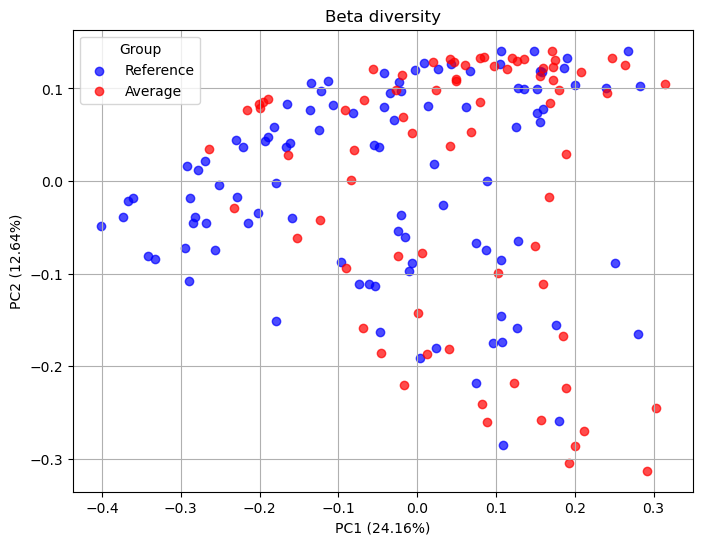

In [16]:
# Load data for both groups
subfam_ref = pd.read_csv('resource/subfam_substrate_ref.csv') 
subfam_rew = pd.read_csv('resource/subfam_substrate_rewell.csv')

# Reorganize the datasets
abundance_subfam_ref = subfam_ref.pivot(index='muestra_id', columns='subfam', values='valor').fillna(0)
abundance_subfam_rew = subfam_rew.pivot(index='muestra_id', columns='subfam', values='valor').fillna(0)

# Combine both groups into a single abundance table
subfam_abundance_table = pd.concat([abundance_subfam_ref, abundance_subfam_rew]).fillna(0)

# **Beta Diversity**
# Calculate beta diversity using Bray-Curtis metric
from skbio.diversity import beta_diversity
metric = 'braycurtis'
beta_matrix_subfam = beta_diversity(metric, subfam_abundance_table.values, ids=subfam_abundance_table.index)

# Convert to a square matrix for visualization
beta_square_subfam = squareform(beta_matrix_subfam.to_data_frame().values)

# **PCoA**
# Perform PCoA
from skbio.stats.ordination import pcoa
pcoa_subfam_results = pcoa(beta_matrix_subfam)

# Extract principal coordinates and add group labels
pcoa_subfam = pcoa_subfam_results.samples
pcoa_subfam['Group'] = ['Reference'] * len(abundance_subfam_ref) + ['Average'] * len(abundance_subfam_rew)

# Function to save the PCoA plot as a PNG
def save_pcoa_subfam_plot_as_png(pcoa_subfam, pcoa_subfam_results, filename):
    """
    Generate and save a PCoA plot for subfamilies beta diversity.

    Args:
        pcoa_subfam (pd.DataFrame): Principal coordinates and group labels.
        pcoa_subfam_results (OrdinationResults): PCoA results for explained variance.
        filename (str): Output filename for the PNG.
    """
    # Create the plot
    plt.figure(figsize=(8, 6))
    color_map = {'Reference': 'blue', 'Average': 'red'}

    for group, color in color_map.items():
        subset = pcoa_subfam[pcoa_subfam['Group'] == group]
        plt.scatter(subset['PC1'], subset['PC2'], alpha=0.7, c=color, label=group)

    plt.title("Beta diversity")
    plt.xlabel("PC1 (%.2f%%)" % (pcoa_subfam_results.proportion_explained['PC1'] * 100))
    plt.ylabel("PC2 (%.2f%%)" % (pcoa_subfam_results.proportion_explained['PC2'] * 100))
    plt.grid(True)
    plt.legend(title='Group')

    # Save the figure as a PNG
    save_figure_as_png(plt.gcf(), filename)


# Call the function to save the plot
save_pcoa_subfam_plot_as_png(pcoa_subfam, pcoa_subfam_results, "fig_1e")


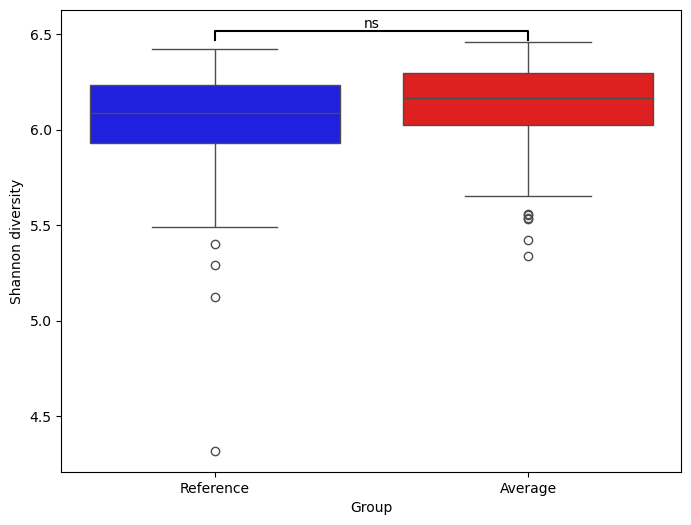

In [17]:
# Function to add the line and significance annotation
def add_significance_line(ax, group1, group2, y_position, p_value):
    """
    Adds a line and significance annotation between two groups.
    Only draws if p_value <= 0.05.
    """
    # Determine significance level
    significance = "ns" if p_value > 0.05 else (
        "*" if p_value <= 0.05 else (
        "**" if p_value <= 0.01 else (
        "***" if p_value <= 0.001 else "****")))

    # Draw the line and annotation only if significant
    if significance:
        x1, x2 = group1, group2
        y, h, col = y_position, 0.05, 'k'
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)  # Line
        ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col)  # Text


# **Alpha Diversity**
# Calculate alpha diversity metrics
metrics = ['shannon']
alpha_subfam_ref = {metric: alpha_diversity(metric, abundance_subfam_ref.values, abundance_subfam_ref.index)
                 for metric in metrics}
alpha_subfam_rew = {metric: alpha_diversity(metric, abundance_subfam_rew.values, abundance_subfam_rew.index)
                 for metric in metrics}

# Convert results to a DataFrame
alpha_subfam_ref = pd.DataFrame(alpha_subfam_ref, index=abundance_subfam_ref.index)
alpha_subfam_rew = pd.DataFrame(alpha_subfam_rew, index=abundance_subfam_rew.index)

# Add a column indicating the group ('ref' or 'rew')
alpha_subfam_ref['Group'] = 'Reference'
alpha_subfam_rew['Group'] = 'Average'

# Concatenate DataFrames from both groups
alpha_subfam_combined = pd.concat([alpha_subfam_ref, alpha_subfam_rew])

# Transform to long format for the boxplot using melt
alpha_subfam_long = alpha_subfam_combined.reset_index().melt(id_vars=['Group'], var_name='Metric', value_name='Alpha Diversity')

# Ensure the column is numeric and handle missing values
alpha_subfam_long['Alpha Diversity'] = pd.to_numeric(alpha_subfam_long['Alpha Diversity'], errors='coerce')
alpha_subfam_long = alpha_subfam_long.dropna(subset=['Alpha Diversity'])

# Filter the DataFrame for each metric separately
alpha_subfam_shannon = alpha_subfam_long[alpha_subfam_long['Metric'] == 'shannon']

# Create boxplots with significance lines
metrics_data = [
    (alpha_subfam_shannon, "Alpha diversity (Shannon)", "Shannon diversity"),
]

for data, title, ylabel in metrics_data:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Group', y='Alpha Diversity', data=data, palette=custom_palette, hue='Group')
    # plt.title(title)
    plt.xlabel("Group")
    plt.ylabel(ylabel)
    
    # Perform the t-test
    group_ref = data[data['Group'] == 'Reference']['Alpha Diversity']
    group_rew = data[data['Group'] == 'Average']['Alpha Diversity']
    t_stat, p_val = ttest_ind(group_ref, group_rew, nan_policy='omit')  # Ignore missing values
    
    # Add significance line
    ax = plt.gca()
    add_significance_line(ax, 0, 1, max(data['Alpha Diversity']) + 0.01, p_val)
    plt.show()


## Fig 2

C:\Users\milagros.trotta\AppData\Local\Temp\ipykernel_14668\3436952243.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Reference', 'Average'], fontsize=10)  # Custom labels
C:\Users\milagros.trotta\AppData\Local\Temp\ipykernel_14668\3436952243.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Reference', 'Average'], fontsize=10)  # Custom labels
C:\Users\milagros.trotta\AppData\Local\Temp\ipykernel_14668\3436952243.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Reference', 'Average'], fontsize=10)  # Custom labels
C:\Users\milagros.trotta\AppData\Local\Temp\ipykernel_14668\3436952243.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of 

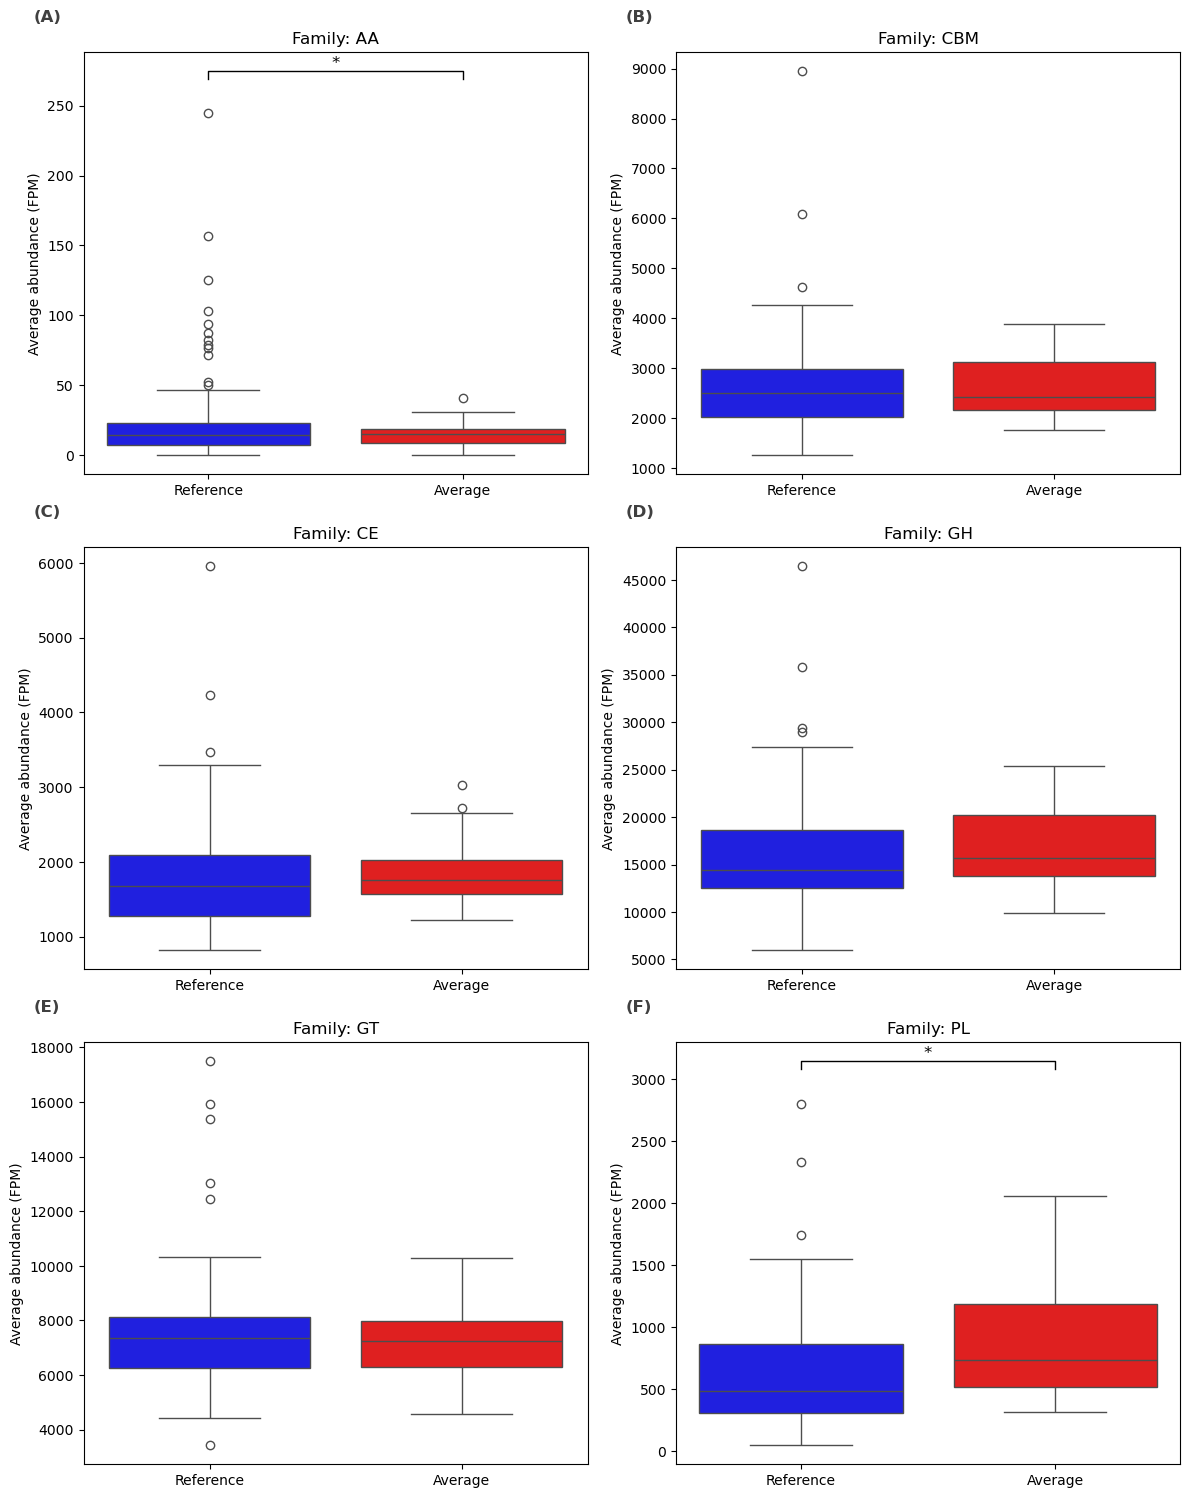

In [20]:
import string

# Function to add letters to the subplots
def add_subplot_letter(ax, letter):
    """
    Adds a letter to the top-left corner of a subplot.
    """
    ax.text(
        -0.1, 1.1, f"({letter})", transform=ax.transAxes,
        fontsize=12, fontweight='bold', color='#404040', va='top', ha='left'
    )

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows), sharex=False)
axes = axes.flatten()  # Flatten for easy iteration

# Alphabet for subplot labels
alphabet = list(string.ascii_uppercase)

# Loop through each family and its subplot
for idx, (ax, familia) in enumerate(zip(axes, familias)):
    # Filter data for the current family
    familia_data = data[data['familia'] == familia]
    
    # Split the groups
    grupo_dbref = familia_data[familia_data['grupo'] == 'Reference']['value']
    grupo_rewell = familia_data[familia_data['grupo'] == 'Average']['value']
    
    # Perform the t-test
    t_stat, p_value = ttest_ind(grupo_dbref, grupo_rewell, equal_var=False)

    # Create the boxplot for this family
    sns.boxplot(
        data=familia_data,
        x='grupo',
        y='value',
        ax=ax,
        palette=custom_palette,
        hue='grupo'
    )
    
    # Add the t-test result to the plot if significant
    if p_value <= 0.05:
        significance = '*' if p_value > 0.01 else '**' if p_value > 0.001 else '***'
        max_y = familia_data['value'].max()
        add_significance_bar(ax, 0, 1, max_y + 0.1 * max_y, significance)
    
    # Customize the plot
    ax.set_title(f'Family: {familia}')
    ax.set_xlabel('')  # Remove default X-axis label
    ax.set_ylabel('Average abundance (FPM)')
    ax.set_xticklabels(['Reference', 'Average'], fontsize=10)  # Custom labels
    
    # Add subplot letter
    add_subplot_letter(ax, alphabet[idx])

# Disable extra plots if there are unused subplots
for ax in axes[num_familias:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the figure as a high-quality PNG
fig.savefig("supp_fig_1", dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


## Fig 3

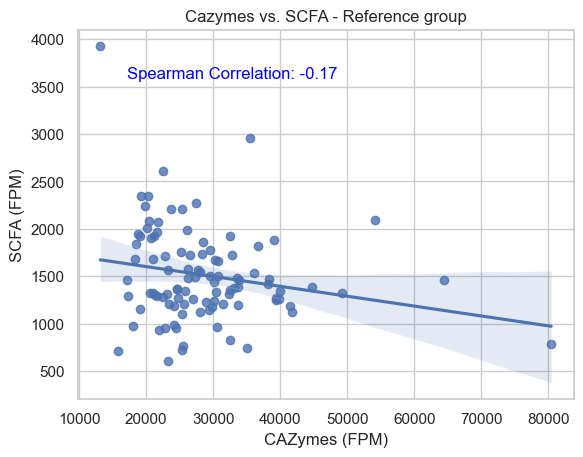

In [21]:
dbref_scfa = pd.read_csv('resource/cazy-scfa-ref.csv')
rew_scfa = pd.read_csv('resource/cazy-scfa-rew.csv')

# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(dbref_scfa['SUM_cazy'])
stat_y, p_value_y = stats.shapiro(dbref_scfa['suma_scfa'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(dbref_scfa['SUM_cazy'], dbref_scfa['suma_scfa'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(dbref_scfa['SUM_cazy'], dbref_scfa['suma_scfa'])
    corr_type = "Spearman"

# Set the style of the plots
sns.set(style="whitegrid")

# Create the plot
sns.regplot(x='SUM_cazy', y='suma_scfa', data=dbref_scfa)

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='blue', verticalalignment='top')

# Titles and labels
plt.title("Cazymes vs. SCFA - Reference group")
plt.xlabel("CAZymes (FPM)")
plt.ylabel("SCFA (FPM)")

# Show the plot
plt.show()


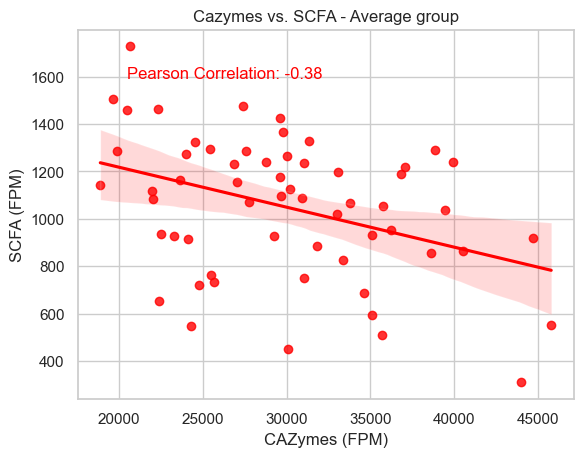

In [22]:
# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(rew_scfa['SUM_cazy'])
stat_y, p_value_y = stats.shapiro(rew_scfa['suma_scfa'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(rew_scfa['SUM_cazy'], rew_scfa['suma_scfa'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(rew_scfa['SUM_cazy'], rew_scfa['suma_scfa'])
    corr_type = "Spearman"

# Set the style of the plots
sns.set(style="whitegrid")

# Create the plot with red color
sns.regplot(x='SUM_cazy', y='suma_scfa', data=rew_scfa, color='red')

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='red', verticalalignment='top')

# Titles and labels
plt.title("Cazymes vs. SCFA - Average group")
plt.xlabel("CAZymes (FPM)")
plt.ylabel("SCFA (FPM)")

# Show the plot
plt.show()


## Fig 4

In [23]:
pl_scfa_ref= pd.read_csv('resource/PL-AGCC-REF.csv')
pl_scfa_rew= pd.read_csv('resource/PL-AGCC-REW.csv')
gh_scfa_ref= pd.read_csv('resource/GH-AGCC-REF.csv')
gh_scfa_rew= pd.read_csv('resource/GH-AGCC-REW.csv')

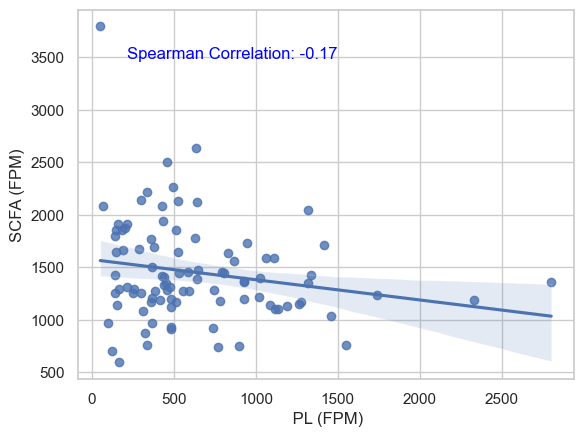

In [24]:
# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(pl_scfa_ref['SUM(SUM_Cazy)'])
stat_y, p_value_y = stats.shapiro(pl_scfa_ref['MAX(scfa_full)'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(pl_scfa_ref['SUM(SUM_Cazy)'], pl_scfa_ref['MAX(scfa_full)'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(pl_scfa_ref['SUM(SUM_Cazy)'], pl_scfa_ref['MAX(scfa_full)'])
    corr_type = "Spearman"

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
sns.regplot(x='SUM(SUM_Cazy)', y='MAX(scfa_full)', data=pl_scfa_ref)

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='blue', verticalalignment='top')

# Titles and labels
plt.xlabel(" PL (FPM)")
plt.ylabel("SCFA (FPM)")

# Show the plot
plt.show()


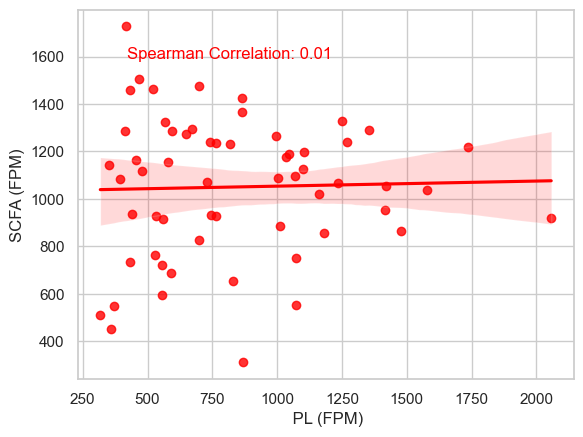

In [25]:
# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(pl_scfa_rew['SUM(SUM_Cazy)'])
stat_y, p_value_y = stats.shapiro(pl_scfa_rew['MAX(scfa_full)'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(pl_scfa_rew['SUM(SUM_Cazy)'], pl_scfa_rew['MAX(scfa_full)'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(pl_scfa_rew['SUM(SUM_Cazy)'], pl_scfa_rew['MAX(scfa_full)'])
    corr_type = "Spearman"

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
sns.regplot(x='SUM(SUM_Cazy)', y='MAX(scfa_full)', data=pl_scfa_rew, color='red')

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='red', verticalalignment='top')

# Titles and labels
#plt.title("PL - SCFA - wellness group")
plt.xlabel(" PL (FPM)")
plt.ylabel("SCFA (FPM)")

# Show the plot
plt.show()


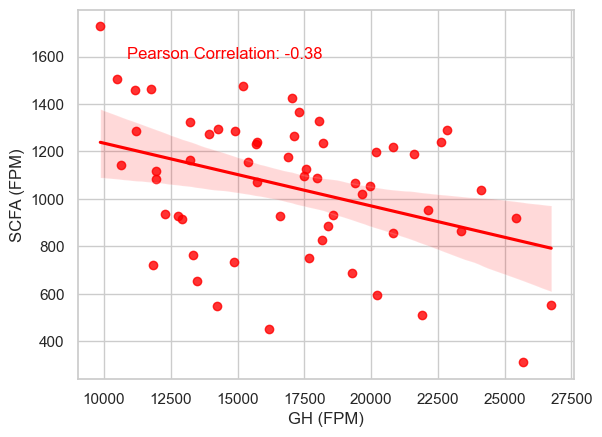

In [26]:
# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(gh_scfa_rew['SUM(SUM_Cazy)'])
stat_y, p_value_y = stats.shapiro(gh_scfa_rew['MAX(scfa_full)'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(gh_scfa_rew['SUM(SUM_Cazy)'], gh_scfa_rew['MAX(scfa_full)'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(gh_scfa_rew['SUM(SUM_Cazy)'], gh_scfa_rew['MAX(scfa_full)'])
    corr_type = "Spearman"

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
sns.regplot(x='SUM(SUM_Cazy)', y='MAX(scfa_full)', data=gh_scfa_rew, color='red')

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='red', verticalalignment='top')

# Titles and labels
#plt.title("GH - SCFA - wellness group")
plt.xlabel("GH (FPM)")
plt.ylabel("SCFA (FPM)")

# Show the plot
plt.show()


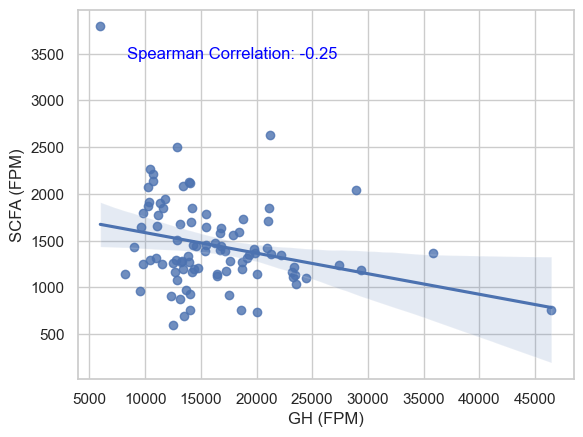

In [27]:
# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(gh_scfa_ref['SUM(SUM_Cazy)'])
stat_y, p_value_y = stats.shapiro(gh_scfa_ref['MAX(scfa_full)'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(gh_scfa_ref['SUM(SUM_Cazy)'], gh_scfa_ref['MAX(scfa_full)'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(gh_scfa_ref['SUM(SUM_Cazy)'], gh_scfa_ref['MAX(scfa_full)'])
    corr_type = "Spearman"

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
sns.regplot(x='SUM(SUM_Cazy)', y='MAX(scfa_full)', data=gh_scfa_ref)

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='blue', verticalalignment='top')

# Titles and labels
#plt.title("GH - SCFA - reference group")
plt.xlabel("GH (FPM)")
plt.ylabel("SCFA (FPM)")

# Show the plot
plt.show()


## Fig 5

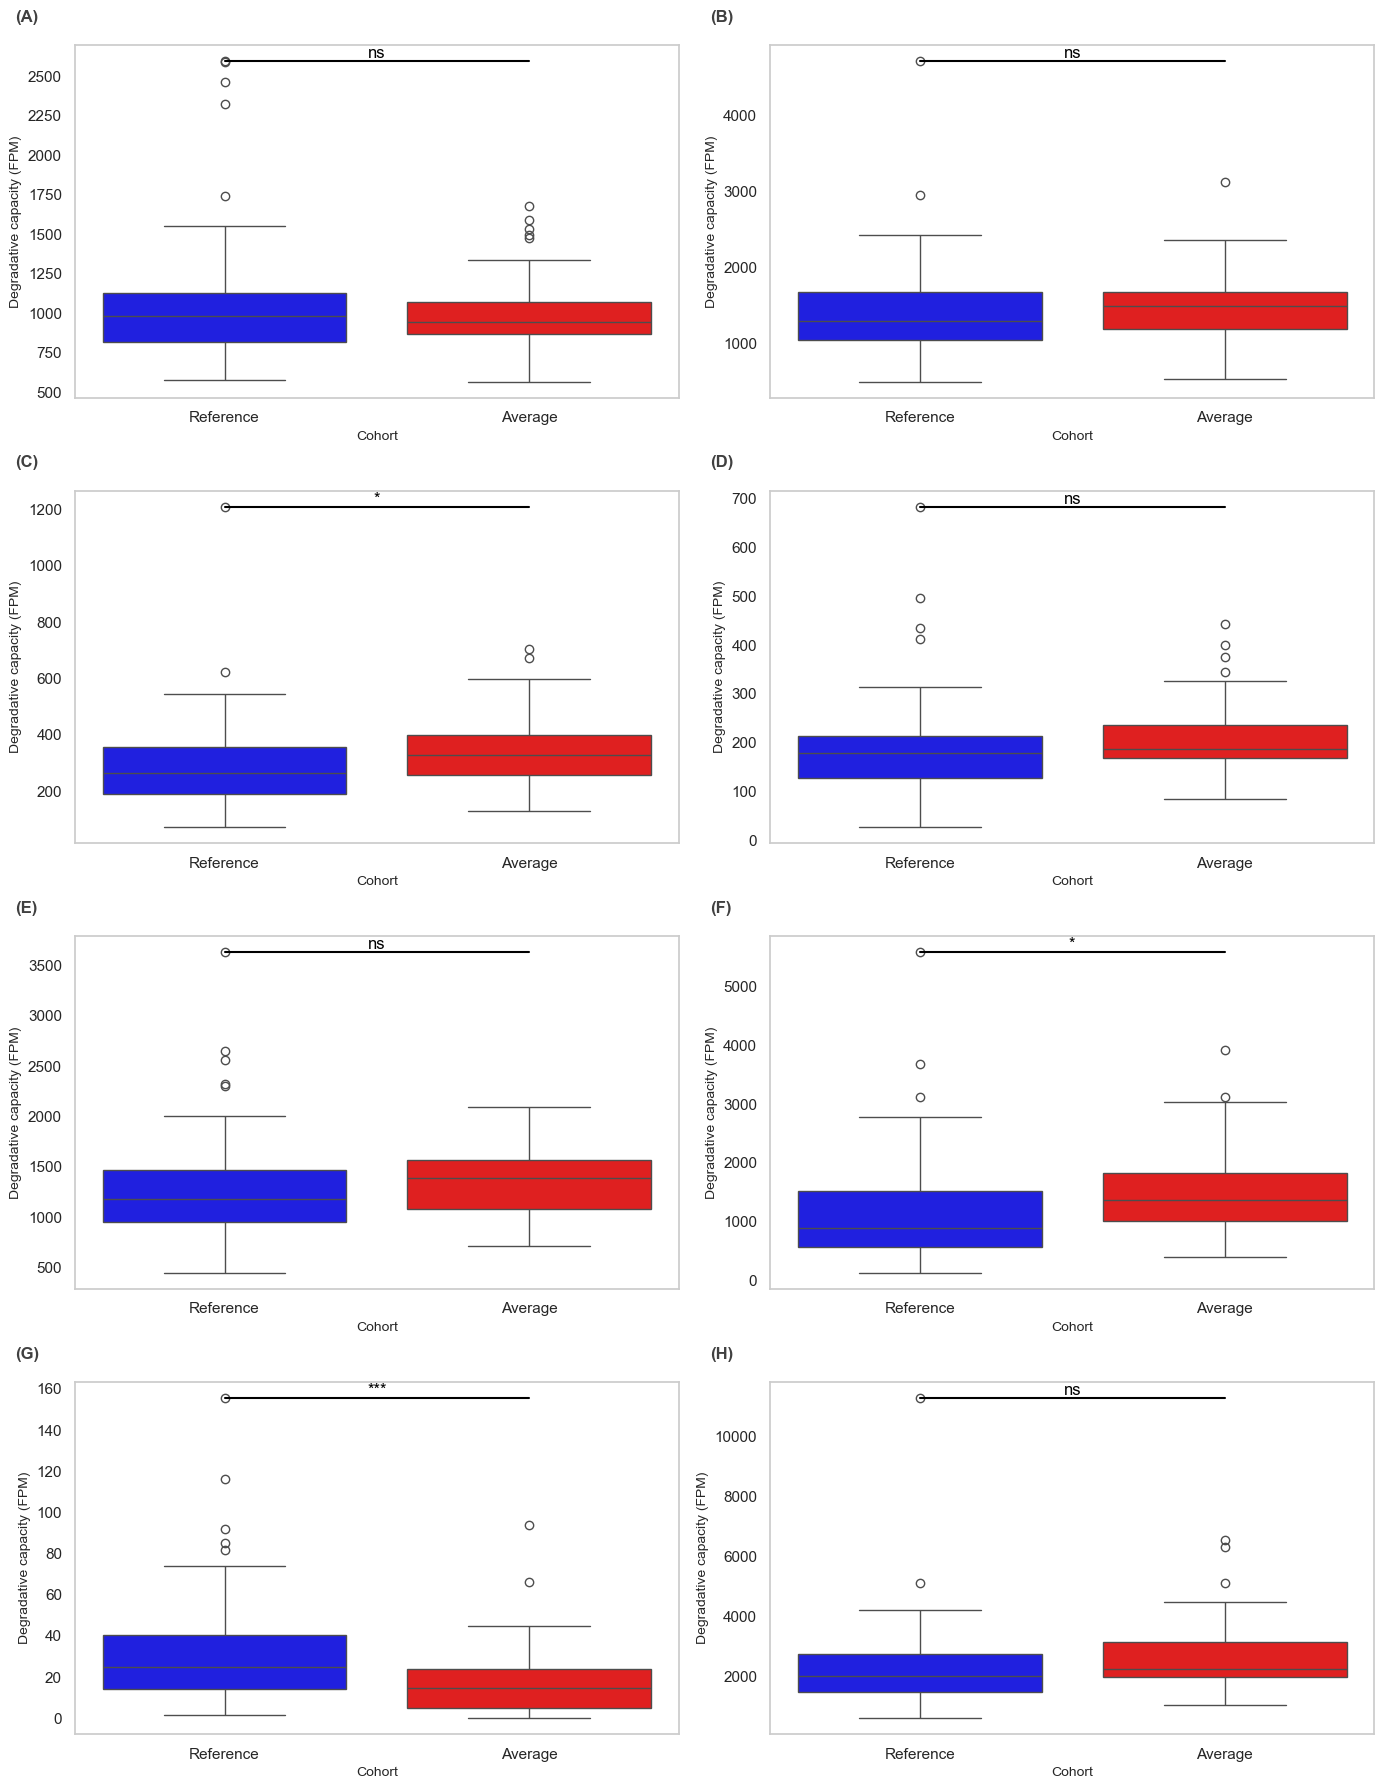

In [33]:
# Load the dataframes
dataframes = [
    ('starch_ref', pd.read_csv('resource/cap-deg-almidon-ref.csv')),
    ('starch_rew', pd.read_csv('resource/cap-deg-almidon-rew.csv')),
    ('betaglucan_ref', pd.read_csv('resource/cap-deg-betaglucano-ref.csv')),
    ('betaglucan_rew', pd.read_csv('resource/cap-deg-betaglucano-rew.csv')),
    ('celullose_ref', pd.read_csv('resource/cap-deg-celulosa-ref.csv')),
    ('celullose_rew', pd.read_csv('resource/cap-deg-celulosa-rew.csv')),
    ('fos_ref', pd.read_csv('resource/cap-deg-FOS-ref.csv')),
    ('fos_rew', pd.read_csv('resource/cap-deg-fructan-rew.csv')),
    ('galactan_ref', pd.read_csv('resource/cap-deg-galac-ref.csv')),
    ('galactan_rew', pd.read_csv('resource/cap-deg-galac-rew.csv')),
    ('pectin_ref', pd.read_csv('resource/cap-deg-pectina-ref.csv')),
    ('pectin_rew', pd.read_csv('resource/cap-deg-pectina-rew.csv')),
    ('raffinose_ref', pd.read_csv('resource/cap-deg-rafinosa-ref.csv')),
    ('raffinose_rew', pd.read_csv('resource/cap-deg-rafinosa-rew.csv')),
    ('xylan_ref', pd.read_csv('resource/cap-deg-xilano-ref.csv')),
    ('xylan_rew', pd.read_csv('resource/cap-deg-xilano-rew.csv'))
]

# Define specific colors for each group
custom_palette = {'Reference': 'blue', 'Average': 'red'}

# Create a dictionary to store grouped dataframes
dataframes_grouped = {}

# Group each dataframe by 'muestra_id' and sum the 'SUM_Cazy' column
for name, df in dataframes:
    if df is not None and not df.empty:
        df_grouped = df.groupby('muestra_id').agg({
            'SUM_Cazy': 'sum',
            'substrate': 'first'
        }).reset_index()
        dataframes_grouped[name] = df_grouped

# Function to determine significance level from p-value
def get_significance(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

# Function to add letters to each subplot
def add_subplot_letter(ax, letter, color="#404040"):
    """
    Adds a letter in the top-left corner of a subplot.
    """
    ax.text(
        -0.1, 1.1, f"({letter})", transform=ax.transAxes,
        fontsize=12, fontweight='bold', color=color, va='top', ha='left'
    )

# List of substrates
substrates = ['starch', 'betaglucan', 'celullose', 'fos', 'galactan', 'pectin', 'raffinose', 'xylan']

# Create subplots
fig, axes = plt.subplots(nrows=(len(substrates) + 1) // 2, ncols=2, figsize=(14, 18))
axes = axes.flatten()

# Alphabet for subplot letters
alphabet = list(string.ascii_uppercase)

# Iterate through the substrates and create boxplots
for idx, (ax, substrate) in enumerate(zip(axes, substrates)):
    df_ref = dataframes_grouped.get(f'{substrate}_ref')  # Reference dataframe
    df_rew = dataframes_grouped.get(f'{substrate}_rew')  # Rewell dataframe
    
    if df_ref is not None and df_rew is not None:
        # Add group column for plotting
        df_ref['group'] = 'Reference'
        df_rew['group'] = 'Average'
        
        # Combine both groups into one dataframe
        df_combined = pd.concat([df_ref[['muestra_id', 'SUM_Cazy', 'group']], 
                                 df_rew[['muestra_id', 'SUM_Cazy', 'group']]])
        
        # Create the boxplot
        sns.boxplot(x='group', y='SUM_Cazy', data=df_combined, palette=custom_palette, ax=ax, hue='group')
        
        # Perform t-test between the two groups
        t_stat, p_value = stats.ttest_ind(df_ref['SUM_Cazy'], df_rew['SUM_Cazy'])
        significance = get_significance(p_value)
        
        # Add significance lines and text
        x1, x2 = 0, 1  # Positions of the groups
        y, h, col = df_combined['SUM_Cazy'].max() + 0.1, 0.05, 'black'
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col, fontsize=12)
        
        # Customize axis titles and labels
        #ax.set_title(f'{substrate.capitalize()} (p-value: {p_value:.4f})', fontsize=12)
        ax.set_xlabel('Cohort', fontsize=10)
        ax.set_ylabel('Degradative capacity (FPM)', fontsize=10)
        ax.grid(False)

        # Add subplot letter
        add_subplot_letter(ax, alphabet[idx])
    else:
        # Hide the subplot if there is no data
        ax.set_visible(False)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the figure as a high-quality PNG file
output_path = 'suppl_fig_2.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')

# Display the plot
plt.show()



## Fig 6

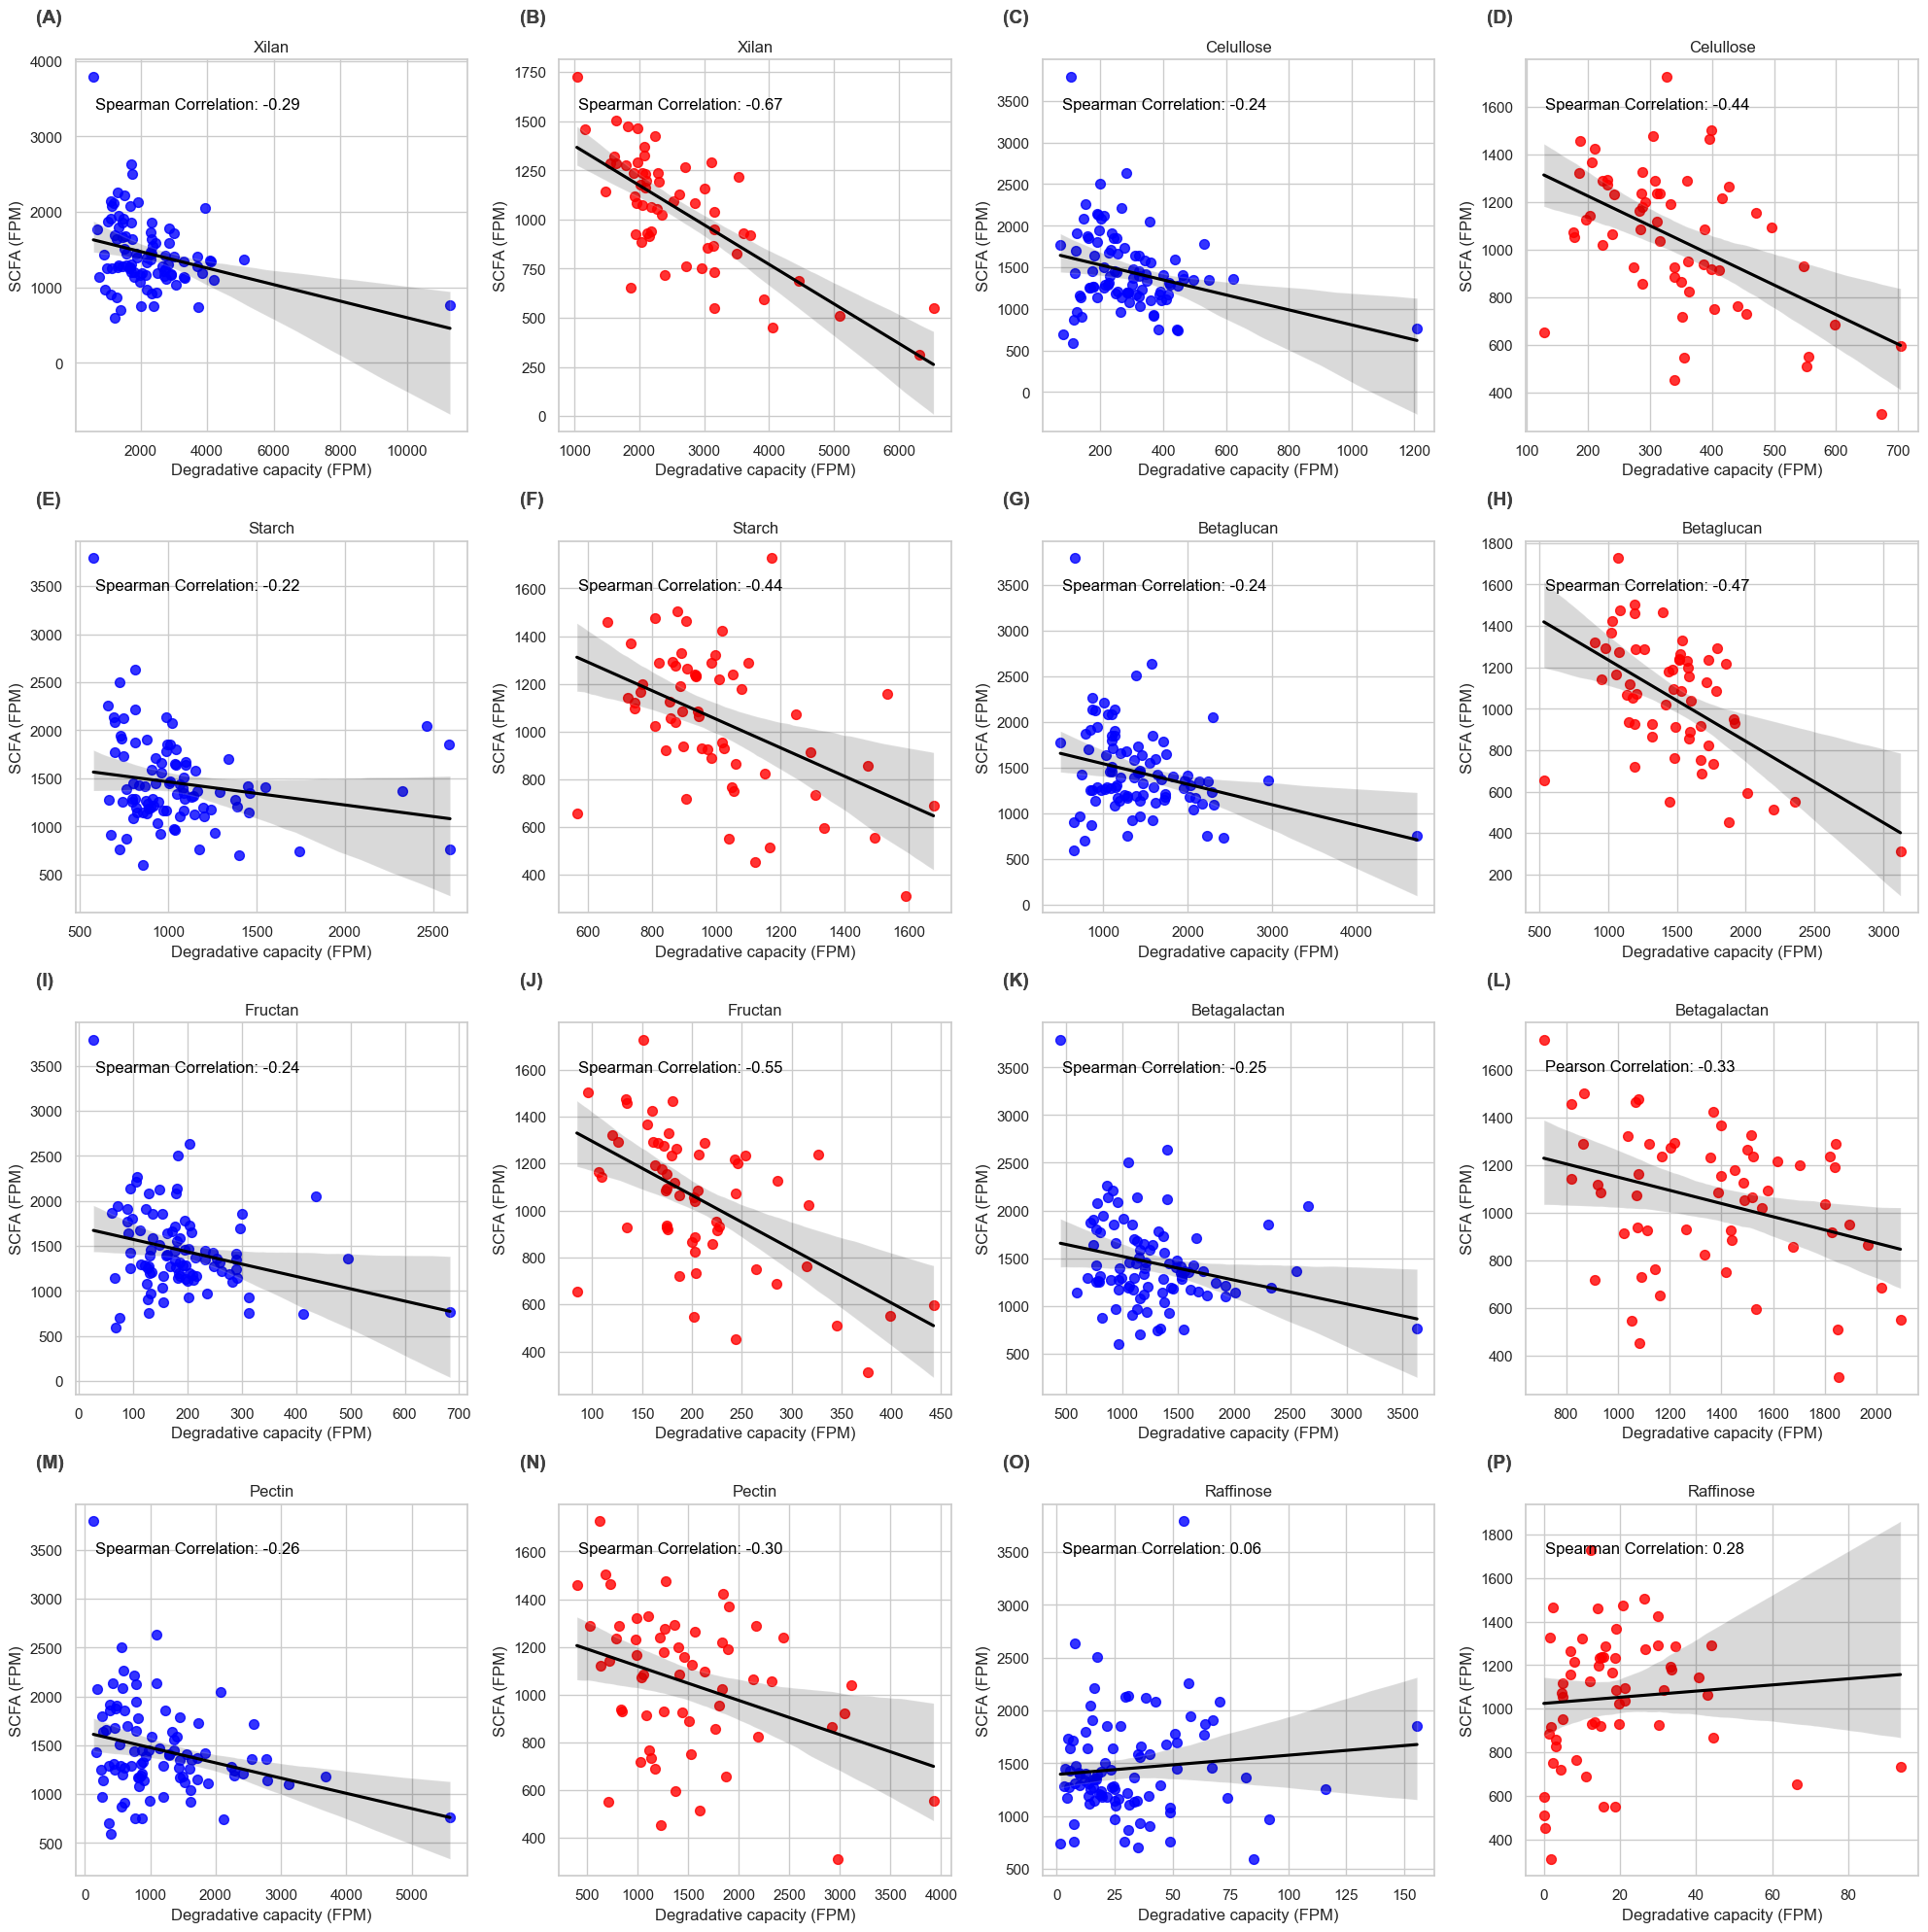

In [36]:
pectina_dbref = pd.read_csv('resource/pectina-agcc-ref.csv')
pectina_rewell = pd.read_csv('resource/pectina-agcc-rew.csv')
rafinosa_dbref = pd.read_csv('resource/rafinosa-agcc-ref.csv')
rafinosa_rewell = pd.read_csv('resource/rafinosa-agcc-rew.csv')
xilano_dbref = pd.read_csv('resource/xilano-agcc-ref.csv')
xilano_rewell = pd.read_csv('resource/xilano-agcc-rew.csv')
celulosa_dbref = pd.read_csv('resource/celulosa-agcc-ref.csv')
celulosa_rewell = pd.read_csv('resource/celulosa-agcc-rew.csv')
almidon_dbref = pd.read_csv('resource/almidon-agcc-ref.csv')
almidon_rewell = pd.read_csv('resource/almidon-agcc-rew.csv')
betaglu_dbref = pd.read_csv('resource/betaglucano-agcc-ref.csv')
betaglu_rewell = pd.read_csv('resource/betaglucano-agcc-rew.csv')
fructan_dbref = pd.read_csv('resource/FOS-agcc-ref.csv')
fructan_rewell = pd.read_csv('resource/FOS-agcc-rew.csv')
betagal_dbref = pd.read_csv('resource/GOS-agcc-ref.csv')
betagal_rewell = pd.read_csv('resource/GOS-agcc-rew.csv')

# Function to calculate correlation and display the plot
def plot_correlation(df, x_column, y_column, title, ax, color, label):
    """
    Generates a correlation plot with a regression line and custom colors.

    Args:
        df (pd.DataFrame): DataFrame with data.
        x_column (str): Name of the column for the X-axis.
        y_column (str): Name of the column for the Y-axis.
        title (str): Title of the plot.
        ax (matplotlib.Axes): Subplot to draw the plot on.
        color (str): Color for the points and regression line.
        label (str): Label to annotate the subplot.
    """
    # Normality test (Shapiro-Wilk) for both variables
    stat_x, p_value_x = stats.shapiro(df[x_column])
    stat_y, p_value_y = stats.shapiro(df[y_column])

    # Determine correlation type based on normality
    if p_value_x > 0.05 and p_value_y > 0.05:
        correlation, _ = stats.pearsonr(df[x_column], df[y_column])
        corr_type = "Pearson"
    else:
        correlation, _ = stats.spearmanr(df[x_column], df[y_column])
        corr_type = "Spearman"

    # Set up the plot style
    sns.set(style="whitegrid")

    # Create the plot on the provided subplot `ax`
    sns.regplot(x=x_column, y=y_column, data=df, ax=ax, color=color, scatter_kws={'s': 50}, line_kws={'color': 'black'})

    # Add correlation value to the plot
    ax.text(0.05, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=ax.transAxes,
            fontsize=12, color='black', verticalalignment='top')

    # Add the letters in dark gray (#404040) at the top-left corner of each subplot
    ax_ref.text(-0.1, 1.1, f'({label_ref})', transform=ax_ref.transAxes, fontsize=14, color='#404040', fontweight='bold')
    ax_wellness.text(-0.1, 1.1, f'({label_wellness})', transform=ax_wellness.transAxes, fontsize=14, color='#404040', fontweight='bold')

    # Set titles and labels
    ax.set_title(title)
    ax.set_xlabel('Degradative capacity (FPM)')
    ax.set_ylabel('SCFA (FPM)')

# Create subplots: (4 rows, 4 columns)
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Substrate information
sustratos = [
    ('xilan', xilano_dbref, xilano_rewell), 
    ('celullose', celulosa_dbref, celulosa_rewell), 
    ('starch', almidon_dbref, almidon_rewell), 
    ('betaglucan', betaglu_dbref, betaglu_rewell),
    ('fructan', fructan_dbref, fructan_rewell),
    ('betagalactan', betagal_dbref, betagal_rewell),
    ('pectin', pectina_dbref, pectina_rewell),
    ('raffinose', rafinosa_dbref, rafinosa_rewell)
]

# Alphabet labels for the plots
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Iterate over substrates and create the plots
for i, (sustrato, df_ref, df_wellness) in enumerate(sustratos):
    row = i // 2
    col = i % 2
    ax_ref = axes[row, col*2]  # Subplot for the reference group (even column)
    ax_wellness = axes[row, col*2 + 1]  # Subplot for the wellness group (odd column)

    # Add labels for the subplots
    label_ref = alphabet[i*2]  # Letter for the reference subplot
    label_wellness = alphabet[i*2 + 1]  # Letter for the wellness subplot

    # Plot for each group (reference and wellness)
    plot_correlation(df_ref, 'SUM(SUM_Cazy)', 'MAX(scfa_full)', f'{sustrato.capitalize()}', ax_ref, color='blue', label=label_ref)
    plot_correlation(df_wellness, 'SUM(SUM_Cazy)', 'MAX(scfa_full)', f'{sustrato.capitalize()}', ax_wellness, color='red', label=label_wellness)

# Adjust spacing between plots
plt.tight_layout()

# Show all plots
plt.show()


In [37]:
# Save the figure as PNG with high resolution (e.g., 300 DPI)
output_path = "fig4.png"
fig.savefig(output_path, dpi=300, format='png', bbox_inches='tight')

## Fig 7

grupo
IBD        2.602857
control    2.860000
Name: divalfa, dtype: float64
Estadístico t: -2.259
Valor p: 0.030


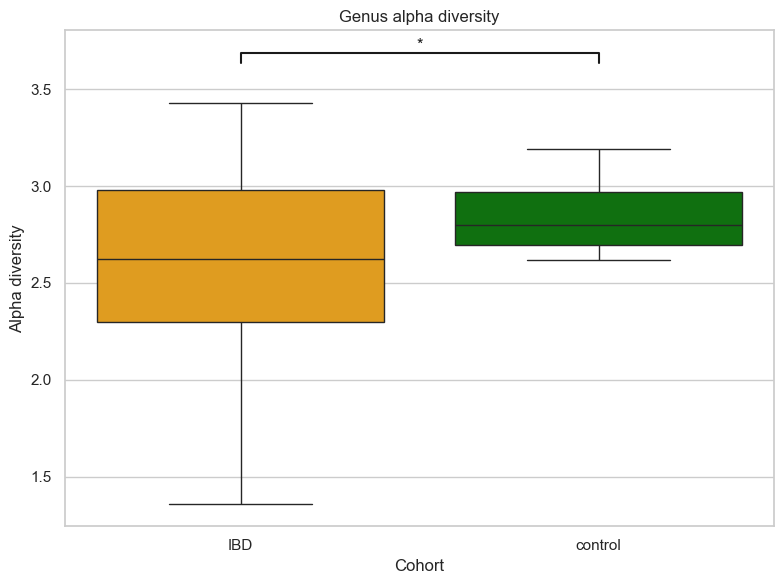

In [38]:
mxmarkers_ibd = pd.read_csv("resource/romagnoli_etiquetados.csv")

mxmarkers_neg = mxmarkers_ibd[mxmarkers_ibd['kit_id'].str.contains('neg')]
mxmarkers_neg

# Define specific colors for each group
custom_palette = {'control': 'green', 'IBD': 'orange'}

# Function to add the significance line and annotation
def add_significance_line(ax, group1, group2, y_position, p_value):
    """Adds a line and significance annotation between two groups."""
    x1, x2 = group1, group2
    y, h, col = y_position, 0.05, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    significance = "ns" if p_value > 0.05 else ("*" if p_value <= 0.05 else ("**" if p_value <= 0.01 else ("***" if p_value <= 0.001 else "****")))
    ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col, fontsize=12)

# Create the plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='grupo', y='divalfa', data=mxmarkers_neg, palette=custom_palette, hue='grupo')

# Labels and title
plt.xlabel('Cohort')
plt.ylabel('Alpha diversity')
plt.title('Genus alpha diversity')

# Calculate the mean for each group (optional, for reference)
mean_per_group_divalfa_neg = mxmarkers_neg.groupby('grupo')['divalfa'].mean()
print(mean_per_group_divalfa_neg)

# Perform t-test
cases_divalfa_neg = mxmarkers_neg[mxmarkers_neg['grupo'] == 'IBD']['divalfa']
controls_divalfa_neg = mxmarkers_neg[mxmarkers_neg['grupo'] == 'control']['divalfa']

t_stat, p_value = stats.ttest_ind(cases_divalfa_neg, controls_divalfa_neg, equal_var=False)  # Welch's t-test

print(f"T statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Add the significance line and p-value to the plot
y_max = mxmarkers_neg['divalfa'].max()  # Get the maximum y value
margin = 0.1 * (y_max - mxmarkers_neg['divalfa'].min())  # Margin based on the range
line_y_position = y_max + margin  # Position of the line

# Indices of the groups in the boxplot (assuming 0 for 'IBD' and 1 for 'control')
add_significance_line(ax, 0, 1, line_y_position, p_value)

# Show the plot
plt.tight_layout()
plt.show()


In [39]:
# Load data
UC = pd.read_csv('resource/run240628NEXromagnoli.resumido.CAZY_values_processed.csv')
CD = pd.read_csv('resource/run240729NEXromagnoli.resumido.CAZY_values_processed.csv')
control = pd.read_csv('resource/run240412NIXromagnoliresumido..CAZY_values_processed 1.csv')
df_rom = pd.concat([UC, CD])

# Filter data where 'tubo' is 'neg'
df_neg = df_rom[df_rom['tubo'] == 'neg']
control_neg = control[control['tubo'] == 'neg']

# Filter data where 'tubo' is 'pos'
df_pos = df_rom[df_rom['tubo'] == 'pos']
control_pos = control[control['tubo'] == 'pos']

# Group by subfamilies
df_pos_subfam = df_pos.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()
control_pos_subfam = control_pos.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()
df_neg_subfam = df_neg.groupby(['subfam', 'kit_id'])['value'].sum().reset_index()
control_neg_subfam = control_neg.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()

# Rename the 'kit_id' column to 'muestra_id' in the dataframes
df_neg_subfam = df_neg_subfam.rename(columns={'kit_id': 'muestra_id'})
df_pos_subfam = df_pos_subfam.rename(columns={'kit_id': 'muestra_id'})

# Reshape the dataset
abundance_subfam_neg_ibd = df_neg_subfam.pivot(index='muestra_id', columns='subfam', values='value').fillna(0)
abundance_subfam_pos_ibd = df_pos_subfam.pivot(index='muestra_id', columns='subfam', values='value').fillna(0)
abundance_subfam_neg_control = control_neg_subfam.pivot(index='muestra_id', columns='subfam', values='value').fillna(0)
abundance_subfam_pos_control = control_pos_subfam.pivot(index='muestra_id', columns='subfam', values='value').fillna(0)




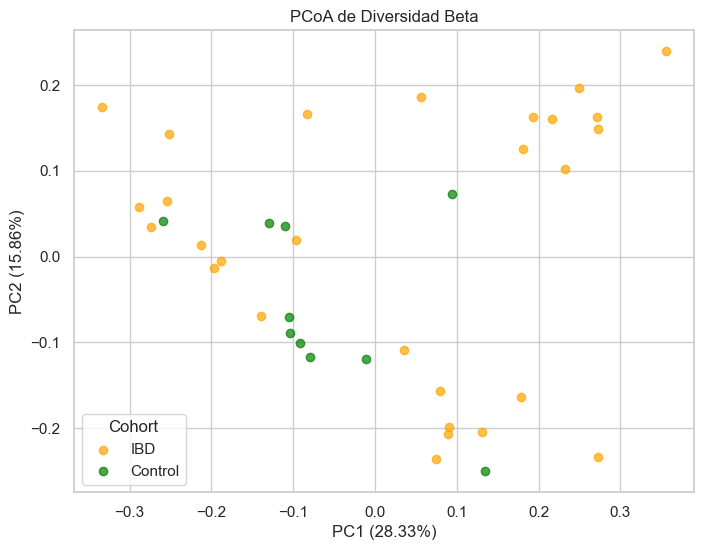

In [21]:
# **Beta Diversity**

# Reshape the dataset
abundance_subfam_neg_ibd = df_neg_subfam.pivot(index='sample_id', columns='subfam', values='value').fillna(0)
abundance_subfam_neg_control = control_neg_subfam.pivot(index='sample_id', columns='subfam', values='value').fillna(0)

# Combine both groups into a single abundance table
subfam_abundance_table_neg = pd.concat([abundance_subfam_neg_ibd, abundance_subfam_neg_control])
subfam_abundance_table_neg = subfam_abundance_table_neg.fillna(0)

# Calculate beta diversity using Bray-Curtis
from skbio.diversity import beta_diversity
metric = 'braycurtis'
beta_matrix_subfam_neg = beta_diversity(metric, subfam_abundance_table_neg.values, ids=subfam_abundance_table_neg.index)

# Convert to a square matrix for visualization
beta_square_subfam_neg = squareform(beta_matrix_subfam_neg.to_data_frame().values)

# **PCoA**
# Perform PCoA
from skbio.stats.ordination import pcoa
pcoa_subfam_results_neg = pcoa(beta_matrix_subfam_neg)

# Extract principal coordinates
pcoa_subfam_neg = pcoa_subfam_results_neg.samples
pcoa_subfam_neg['group'] = ['IBD'] * len(abundance_subfam_neg_ibd) + ['Control'] * len(abundance_subfam_neg_control)  # Assign group

# **Visualization**
plt.figure(figsize=(8, 6))

# Color mapping for groups
color_map = {'IBD': 'orange', 'Control': 'green'}

# Plot each group with labels
for group, color in color_map.items():
    subset = pcoa_subfam_neg[pcoa_subfam_neg['group'] == group]
    plt.scatter(
        subset['PC1'], subset['PC2'], 
        alpha=0.7, c=color, label=group
    )

# Titles and axis labels
plt.title("PCoA of Beta Diversity")
plt.xlabel("PC1 (%.2f%%)" % (pcoa_subfam_results_neg.proportion_explained['PC1'] * 100))
plt.ylabel("PC2 (%.2f%%)" % (pcoa_subfam_results_neg.proportion_explained['PC2'] * 100))
plt.grid(True)

# Add legend with custom title
plt.legend(title='Cohort')

# Show plot
plt.show()


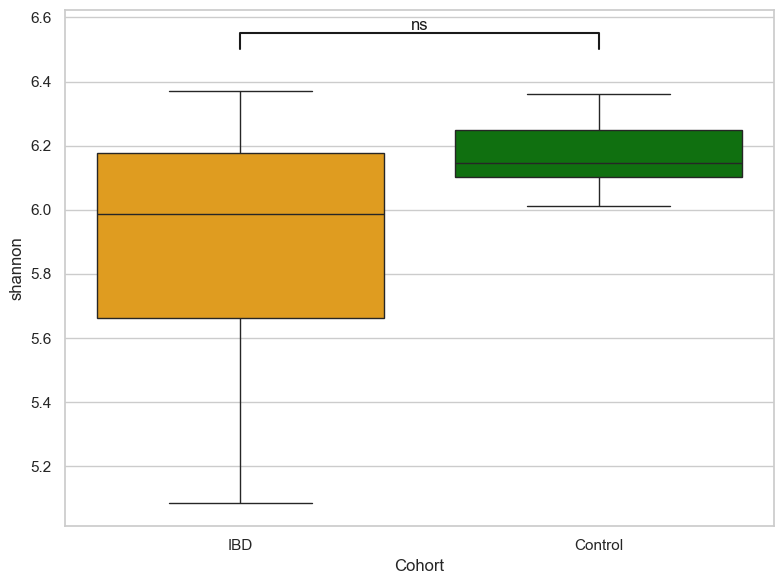

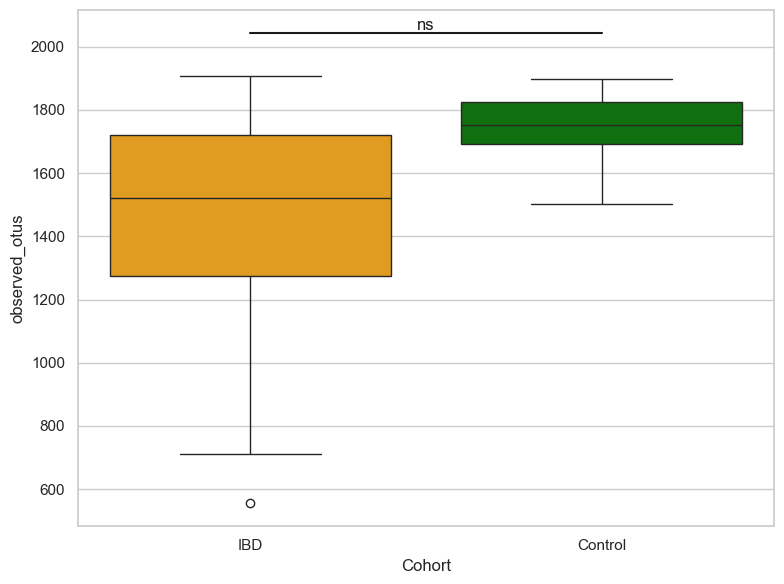

In [28]:
# **Alpha Diversity**
# Calculate alpha diversity metrics
metrics = ['shannon', 'observed_otus']
alpha_subfam_neg_ibd = {metric: alpha_diversity(metric, abundance_subfam_neg_ibd.values, abundance_subfam_neg_ibd.index)
                        for metric in metrics}
alpha_subfam_neg_control = {metric: alpha_diversity(metric, abundance_subfam_neg_control.values, abundance_subfam_neg_control.index)
                            for metric in metrics}

# Convert results to DataFrame
alpha_subfam_neg_ibd_df = pd.DataFrame(alpha_subfam_neg_ibd, index=abundance_subfam_neg_ibd.index)
alpha_subfam_neg_control_df = pd.DataFrame(alpha_subfam_neg_control, index=abundance_subfam_neg_control.index)

# Add a column indicating the group ('IBD' or 'Control')
alpha_subfam_neg_ibd_df['group'] = 'IBD'
alpha_subfam_neg_control_df['group'] = 'Control'

# Color mapping for the groups
color_map = {'IBD': 'orange', 'Control': 'green'}

# Concatenate DataFrames from both groups
alpha_subfam_combined_group = pd.concat([alpha_subfam_neg_ibd_df, alpha_subfam_neg_control_df])

# Function to add significance lines and annotations
def add_significance_line(ax, group1, group2, y_position, p_value):
    """Adds a line and significance annotation between two groups."""
    x1, x2 = group1, group2
    y, h, col = y_position, 0.05, 'k'
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    significance = "ns" if p_value > 0.05 else ("*" if p_value <= 0.05 else ("**" if p_value <= 0.01 else ("***" if p_value <= 0.001 else "****")))
    ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col)

# Iterate through the metrics
for metric in metrics:
    # Values for the two groups
    ibd_neg_values = alpha_subfam_combined_group[alpha_subfam_combined_group['group'] == 'IBD'][metric]
    control_neg_values = alpha_subfam_combined_group[alpha_subfam_combined_group['group'] == 'Control'][metric]
    
    # Calculate p-value (e.g., using t-test or similar)
    t_stat, p_value = ttest_ind(ibd_neg_values, control_neg_values, equal_var=False)

    # Plot Box Plot
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(data=alpha_subfam_combined_group, x='group', y=metric, palette=color_map, hue='group')
    # plt.title(f"{metric}")
    plt.xlabel("Cohort")
    plt.ylabel(metric)
    
    # Dynamically calculate the position for the significance line
    max_y = alpha_subfam_combined_group[metric].max()  # Maximum value for the metric
    margin = 0.1 * (max_y - alpha_subfam_combined_group[metric].min())  # Margin based on the range
    line_y_position = max_y + margin  # Line position

    # Add significance line and annotation
    add_significance_line(ax, 0, 1, line_y_position, p_value)
    
    plt.tight_layout()
    plt.show()


## Fig 8


ANOVA para la métrica 'shannon':
F-statistic: 18.0712, p-value: 7.1815e-09


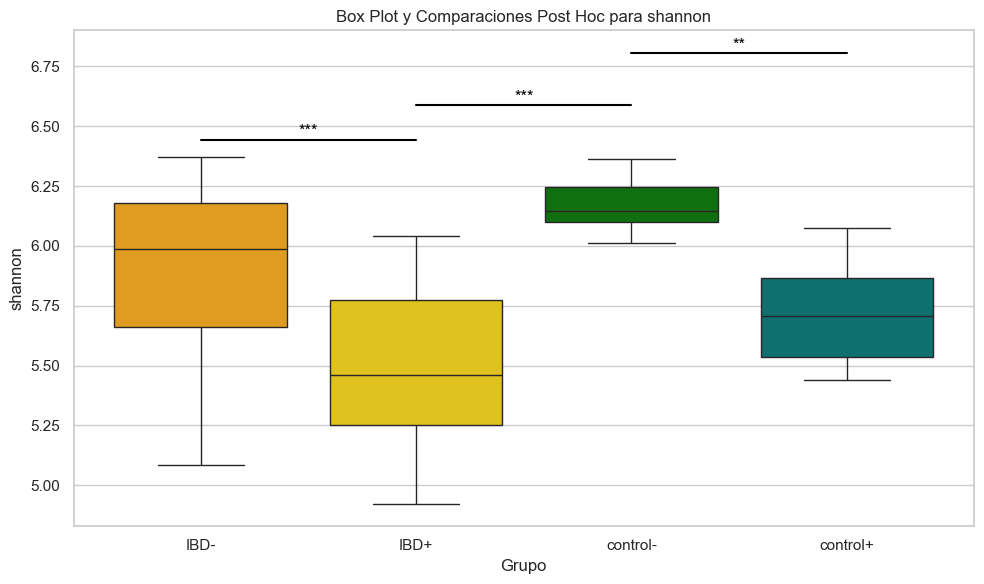


ANOVA para la métrica 'simpson':
F-statistic: 8.3286, p-value: 7.7832e-05


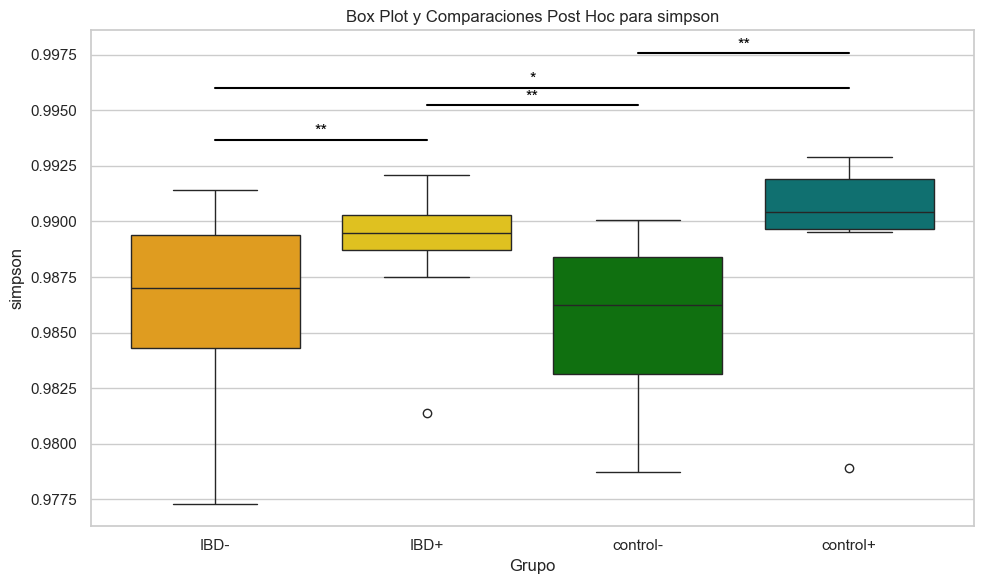


ANOVA para la métrica 'observed_otus':
F-statistic: 11.5271, p-value: 2.8589e-06


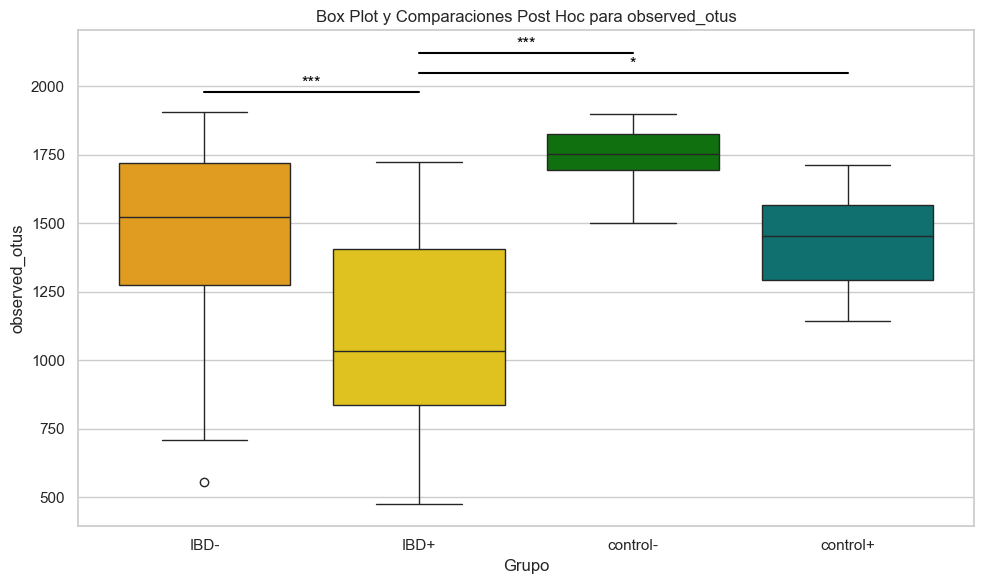

In [29]:
# **Alpha Diversity**
# Calculate alpha diversity metrics
metrics = ['shannon', 'simpson', 'observed_otus']
alpha_subfam_neg_ibd = {metric: alpha_diversity(metric, abundance_subfam_neg_ibd.values, abundance_subfam_neg_ibd.index)
                 for metric in metrics}
alpha_subfam_pos_ibd = {metric: alpha_diversity(metric, abundance_subfam_pos_ibd.values, abundance_subfam_pos_ibd.index)
                 for metric in metrics}
alpha_subfam_neg_control = {metric: alpha_diversity(metric, abundance_subfam_neg_control.values, abundance_subfam_neg_control.index)
                 for metric in metrics}
alpha_subfam_pos_control = {metric: alpha_diversity(metric, abundance_subfam_pos_control.values, abundance_subfam_pos_control.index)
                 for metric in metrics}

# Convert results to DataFrame
alpha_subfam_neg_ibd_df = pd.DataFrame(alpha_subfam_neg_ibd, index=abundance_subfam_neg_ibd.index)
alpha_subfam_pos_ibd_df = pd.DataFrame(alpha_subfam_pos_ibd, index=abundance_subfam_pos_ibd.index)
alpha_subfam_neg_control_df = pd.DataFrame(alpha_subfam_neg_control, index=abundance_subfam_neg_control.index)
alpha_subfam_pos_control_df = pd.DataFrame(alpha_subfam_pos_control, index=abundance_subfam_pos_control.index)

# Add a column indicating the group ('ref' or 'rew')
alpha_subfam_neg_ibd_df['tubo'] = 'IBD-'
alpha_subfam_pos_ibd_df['tubo'] = 'IBD+'
alpha_subfam_neg_control_df['tubo'] = 'control-'
alpha_subfam_pos_control_df['tubo'] = 'control+'

# Concatenate DataFrames from all groups
alpha_subfam_combined_tubo = pd.concat([alpha_subfam_neg_ibd_df, alpha_subfam_pos_ibd_df, alpha_subfam_neg_control_df, alpha_subfam_pos_control_df])

# Color mapping for the groups
color_map = {
    'IBD-': 'orange',       # Orange
    'IBD+': 'gold',         # Gold
    'control-': 'green',    # Green
    'control+': 'teal'      # Teal
}

# Iterate through the metrics
for metric in ['shannon', 'simpson', 'observed_otus']:
    # Perform ANOVA
    ibd_neg_values = alpha_subfam_combined_tubo[alpha_subfam_combined_tubo['tubo'] == 'IBD-'][metric]
    ibd_pos_values = alpha_subfam_combined_tubo[alpha_subfam_combined_tubo['tubo'] == 'IBD+'][metric]
    control_neg_values = alpha_subfam_combined_tubo[alpha_subfam_combined_tubo['tubo'] == 'control-'][metric]
    control_pos_values = alpha_subfam_combined_tubo[alpha_subfam_combined_tubo['tubo'] == 'control+'][metric]
    
    # One-way ANOVA
    anova_result = f_oneway(ibd_neg_values, ibd_pos_values, control_neg_values, control_pos_values)
    print(f"\nANOVA for metric '{metric}':")
    print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")
    
    # Prepare data for Tukey HSD
    tukey_data = alpha_subfam_combined_tubo[[metric, 'tubo']].dropna()
    tukey_test = pairwise_tukeyhsd(endog=tukey_data[metric], groups=tukey_data['tubo'], alpha=0.05)
    
    # Extract results for visualization
    tukey_results = pd.DataFrame(data=tukey_test.summary().data[1:], columns=tukey_test.summary().data[0])

    # Plot Box Plot with p-values and lines overlay
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=alpha_subfam_combined_tubo, x='tubo', y=metric, palette=color_map, hue='tubo')
    plt.title(f"Box Plot and Post Hoc Comparisons for {metric}")
    plt.xlabel("Group")
    plt.ylabel(metric)
    
    # Calculate maximum value and adjust for the lines
    max_y = tukey_data[metric].max()  # Maximum value in the data
    min_y = tukey_data[metric].min()  # Minimum value in the data
    y_increment = (max_y - min_y) * 0.05  # Increment based on the range
    line_offset = y_increment  # Spacing between lines
    
    # Add significance and lines
    for i, row in tukey_results.iterrows():
        group1 = row['group1']
        group2 = row['group2']
        p_value = row['p-adj']
        
        if p_value < 0.05:  # Only for significant comparisons
            group1_idx = ['IBD-', 'IBD+', 'control-', 'control+'].index(group1)
            group2_idx = ['IBD-', 'IBD+', 'control-', 'control+'].index(group2)
            
            # Determine position for the line
            y_pos = max_y + line_offset * (i + 1)  # Incremental height for each comparison
            
            # Draw line
            plt.plot([group1_idx, group2_idx], [y_pos, y_pos], color='black', lw=1.5)
            
            # Determine number of asterisks based on p-value
            if p_value < 0.001:
                significance = '***'
            elif p_value < 0.01:
                significance = '**'
            elif p_value < 0.05:
                significance = '*'
            else:
                significance = 'n.s.'  # Not significant
            
            # Add text with asterisks
            plt.text(
                x=(group1_idx + group2_idx) / 2,
                y=y_pos + (line_offset * 0.2),  # Adjust slightly above the line
                s=significance,
                ha='center',
                fontsize=12,
                color="black"
            )
    
    plt.tight_layout()
    plt.show()


C:\Users\milagros.trotta\AppData\Local\anaconda3\envs\cazymes\Lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.11170606936473541 whereas the largest positive one is 7.209588052426848.
  warn(


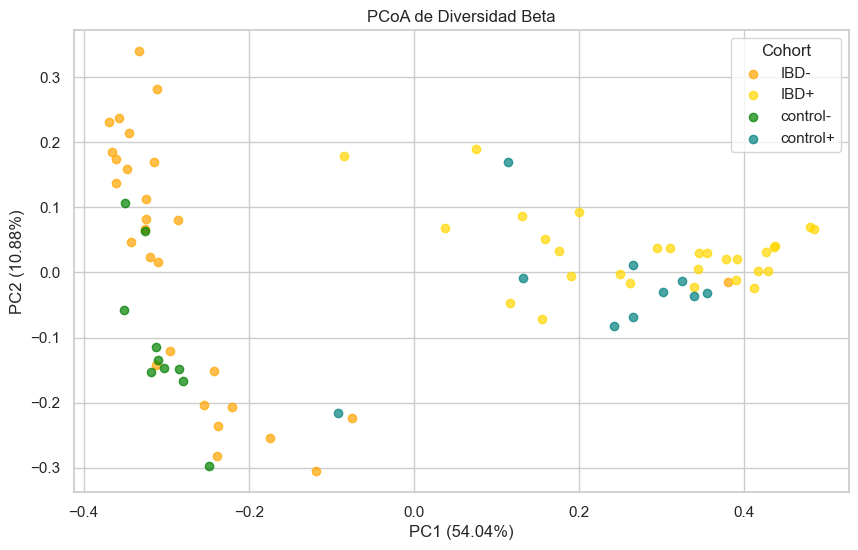

In [30]:
# Combine both groups into a single abundance table
subfam_abundance_table_tubo = pd.concat([abundance_subfam_neg_ibd, abundance_subfam_pos_ibd, abundance_subfam_neg_control, abundance_subfam_pos_control])
subfam_abundance_table_tubo = subfam_abundance_table_tubo.fillna(0)

# **Beta Diversity**
# Calculate beta diversity using Bray-Curtis
from skbio.diversity import beta_diversity
metric = 'braycurtis'
beta_matrix_subfam_tubo = beta_diversity(metric, subfam_abundance_table_tubo.values, ids=subfam_abundance_table_tubo.index)

# Convert to a square matrix for visualization
beta_square_subfam_tubo = squareform(beta_matrix_subfam_tubo.to_data_frame().values)

# **PCoA**
# Perform PCoA
from skbio.stats.ordination import pcoa
pcoa_subfam_results_tubo = pcoa(beta_matrix_subfam_tubo)

# Extract principal coordinates
pcoa_subfam_tubo = pcoa_subfam_results_tubo.samples
pcoa_subfam_tubo['tubo'] = ['IBD-'] * len(abundance_subfam_neg_ibd) + ['IBD+'] * len(abundance_subfam_pos_ibd) + ['control-'] * len(abundance_subfam_neg_control) + ['control+'] * len(abundance_subfam_pos_control)  # Assign group

# **Visualization**
plt.figure(figsize=(10, 6))

# Color mapping for the groups
color_map = {
    'IBD-': 'orange',       # Orange
    'IBD+': 'gold',         # Gold
    'control-': 'green',    # Green
    'control+': 'teal'      # Teal
}

# Plot each group with labels
for group, color in color_map.items():
    subset = pcoa_subfam_tubo[pcoa_subfam_tubo['tubo'] == group]
    plt.scatter(
        subset['PC1'], subset['PC2'], 
        alpha=0.7, c=color, label=group
    )

# Titles and axis labels
plt.title("PCoA of Beta Diversity")
plt.xlabel("PC1 (%.2f%%)" % (pcoa_subfam_results_tubo.proportion_explained['PC1'] * 100))
plt.ylabel("PC2 (%.2f%%)" % (pcoa_subfam_results_tubo.proportion_explained['PC2'] * 100))
plt.grid(True)

# Add legend
plt.legend(title='Cohort')

# Show plot
plt.show()



## Fig 9

In [45]:
df_pos = df_rom[df_rom['tubo'] == 'pos']
control_pos = control[control['tubo'] == 'pos']
df_pos_subfam = df_pos.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()
df_neg_subfam = df_neg.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()
control_pos_subfam = control_pos.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()
control_neg_subfam = control_neg.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()


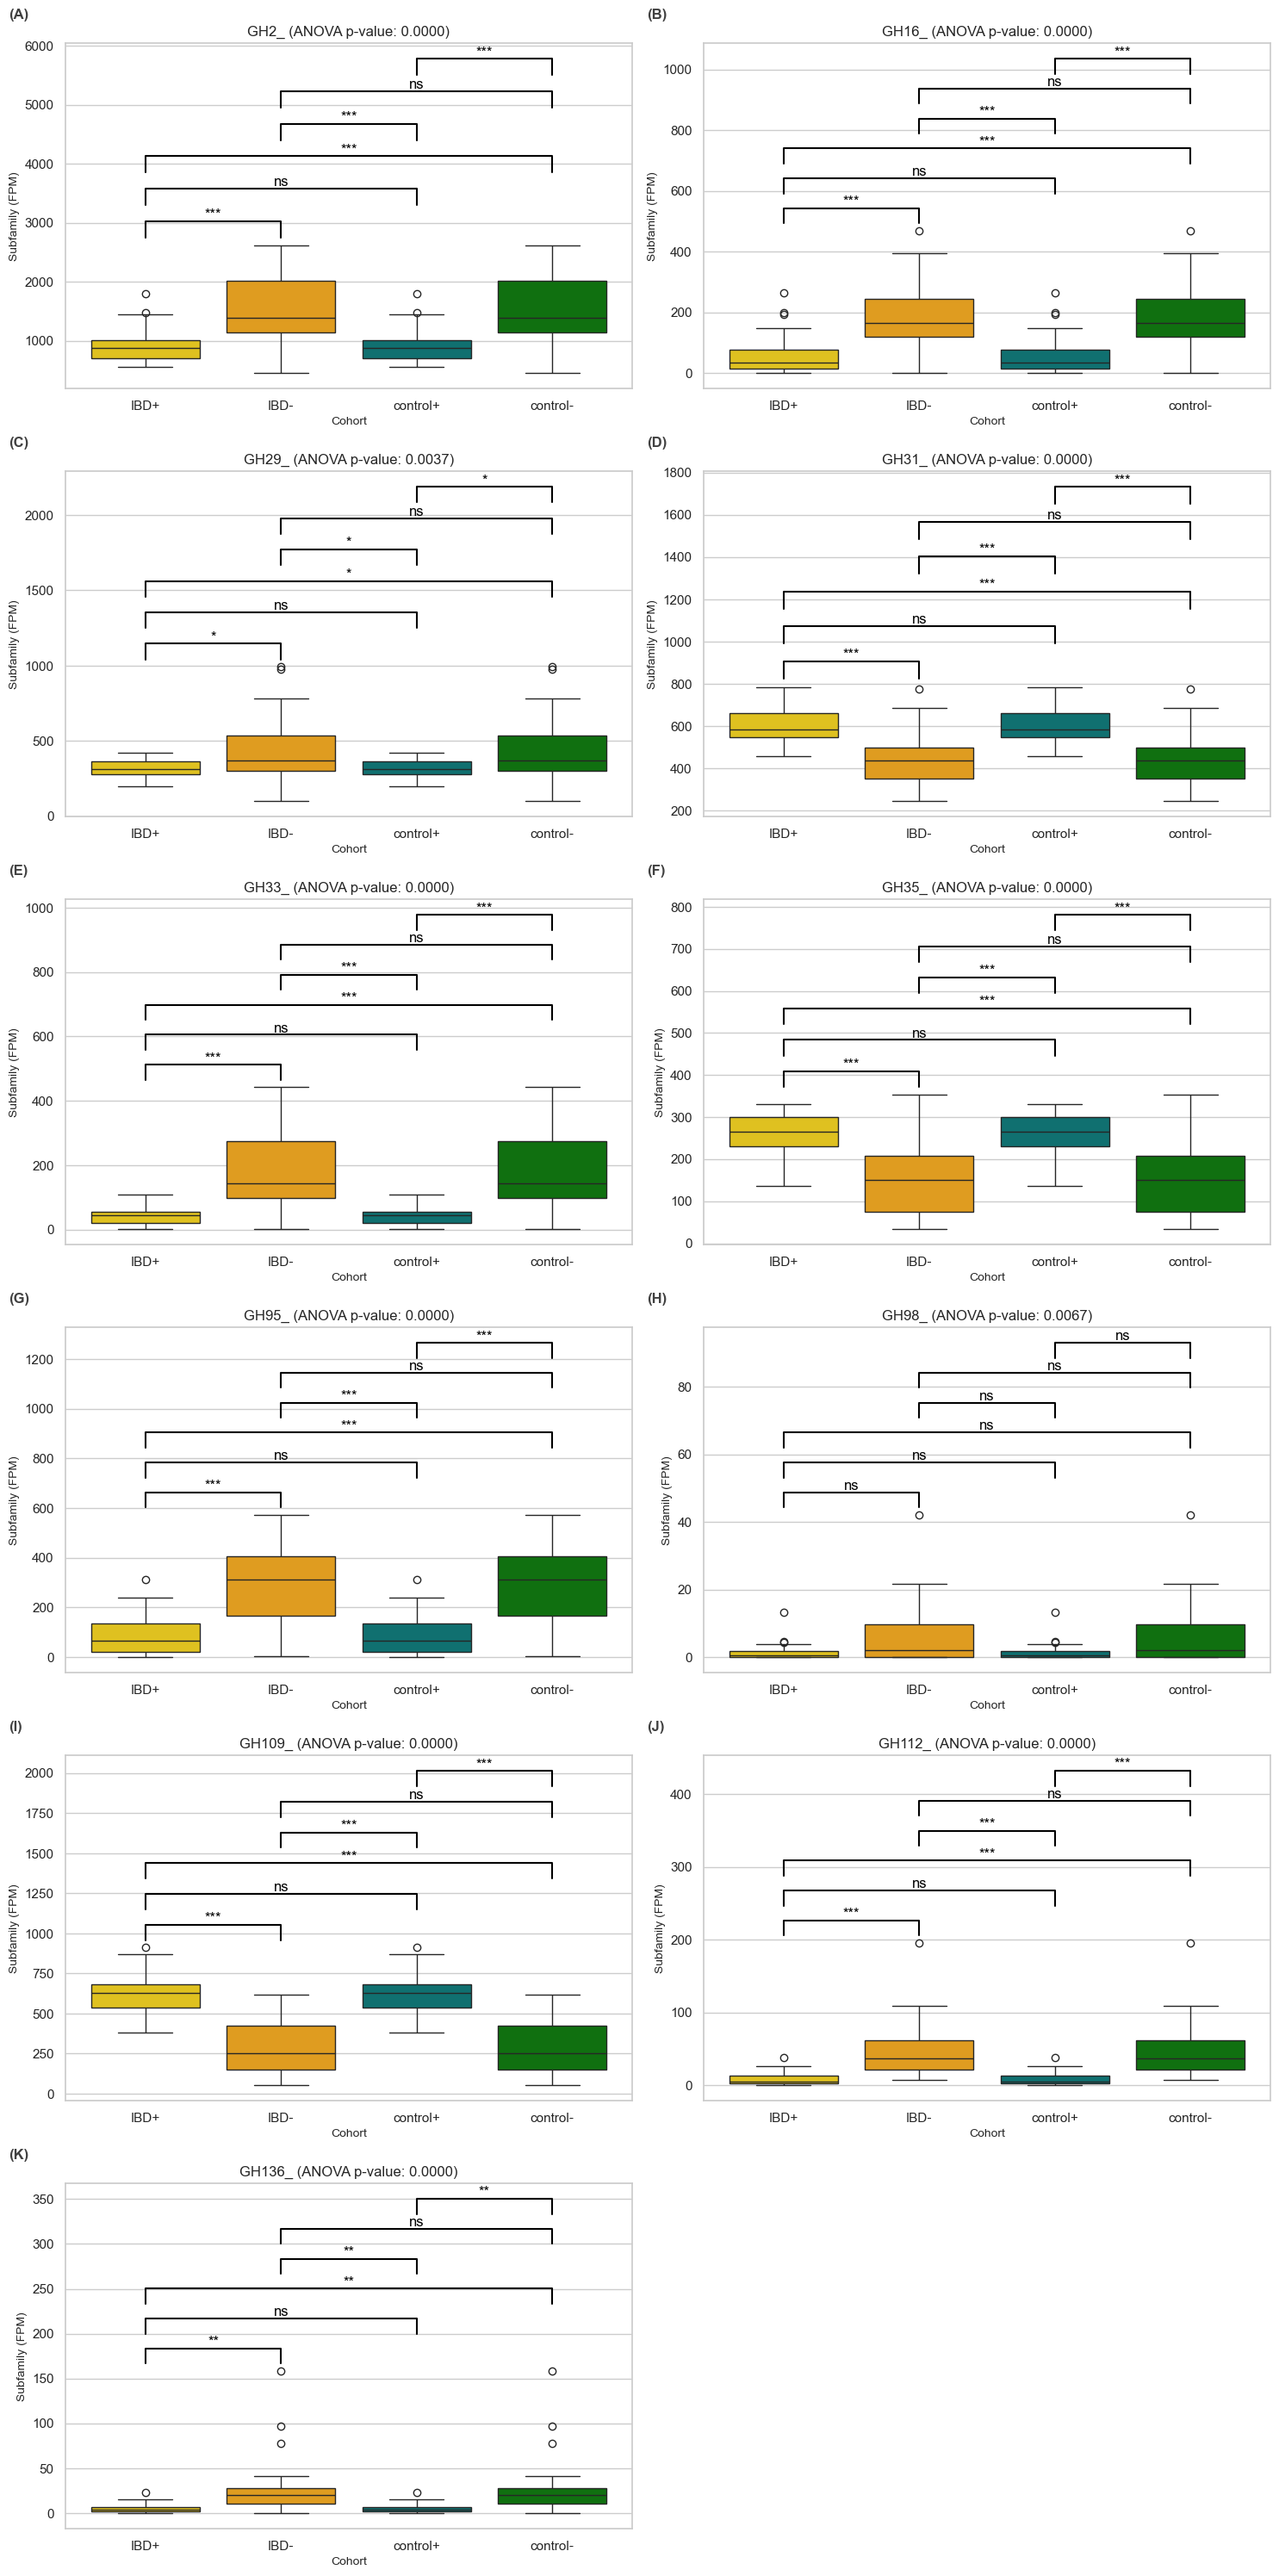

In [46]:
# Create a pattern to search for subfamilies
subfam = ['GH2_', 'GH16_', 'GH29_', 'GH31_', 'GH33_', 'GH35_', 'GH95_', 'GH98_', 'GH109_', 'GH112_', 'GH136_']
pattern = '|'.join(f'^{prefix}' for prefix in subfam)

# Filter the dataframes using prefixes in `subfam`
pos_subfam_filtered = df_pos_subfam[df_pos_subfam['subfam'].str.contains(pattern, regex=True, na=False)]
neg_subfam_filtered = df_neg_subfam[df_neg_subfam['subfam'].str.contains(pattern, regex=True, na=False)]

# Determine the number of rows and columns for subplots
nrows = len(subfam) // 2 + len(subfam) % 2  # Round up for an odd number of subfamilies
ncols = 2

# Create organized subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

# Function to determine the number of stars based on p-value
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# Function to add letters to each subplot
def add_subplot_letter(ax, letter, color="#404040"):
    """
    Adds a letter in the top-left corner of a subplot.
    """
    ax.text(
        -0.1, 1.1, f"({letter})", transform=ax.transAxes,
        fontsize=12, fontweight='bold', color=color, va='top', ha='left'
    )

# Iterate over the subfamilies
alphabet = list(string.ascii_uppercase)  # Generate letters for labeling
for idx, (ax, subfam_item) in enumerate(zip(axes, subfam)):
    # Create grouped dataframes for each group (IBD_Pos, IBD_Neg, etc.)
    dataframes_ibd = {}
    datasets_ibd = {
        'IBD+': pos_subfam_filtered,
        'IBD-': neg_subfam_filtered,
        'control+': pos_subfam_filtered,
        'control-': neg_subfam_filtered
    }
    
    for group_name, dataset_ibd in datasets_ibd.items():
        # Filter subfamilies by the current prefix
        df_filtered_ibd = dataset_ibd[dataset_ibd['subfam'].str.contains(f'^{subfam_item}', regex=True, na=False)].copy()
        
        if not df_filtered_ibd.empty:
            # Group by `muestra_id` and sum values
            df_grouped_ibd = df_filtered_ibd.groupby('muestra_id').agg({
                'value': 'sum',
                'subfam': 'first'  # Optional: Keep the first subfamily as reference
            }).reset_index()
            
            # Add the group column
            df_grouped_ibd['group'] = group_name
            
            # Store in the dictionary
            dataframes_ibd[group_name] = df_grouped_ibd
    
    # Combine all grouped dataframes into one
    df_combined_subfam_ibd = pd.concat(dataframes_ibd.values(), ignore_index=True)
    
    color_map = {
        'IBD-': 'orange',
        'IBD+': 'gold',
        'control-': 'green',
        'control+': 'teal'
    }
    
    # Create the boxplot
    sns.boxplot(x='group', y='value', hue='group', data=df_combined_subfam_ibd, palette=color_map, ax=ax, dodge=False)
    ax.legend([], [], frameon=False)  # Hide individual legends
    
    # Perform ANOVA
    groups_ibd = [df_combined_subfam_ibd[df_combined_subfam_ibd['group'] == group]['value'] for group in df_combined_subfam_ibd['group'].unique()]
    f_stat, p_value = stats.f_oneway(*groups_ibd)
    
    # Add title with ANOVA p-value
    ax.set_title(f'{subfam_item} (ANOVA p-value: {p_value:.4f})', fontsize=12)
    ax.set_xlabel('Cohort', fontsize=10)
    ax.set_ylabel('Subfamily (FPM)', fontsize=10)
    
    # If the ANOVA p-value is significant, perform Tukey's test
    if p_value < 0.05:
        tukey_result = pairwise_tukeyhsd(df_combined_subfam_ibd['value'], df_combined_subfam_ibd['group'], alpha=0.05)
        
        # Initial height for the lines
        max_val = df_combined_subfam_ibd['value'].max() * 1.05
        increment = max_val * 0.1

        # Draw lines and stars for significant comparisons
        for comparison in tukey_result.summary().data[1:]:
            group1, group2, meandiff, p_val, reject = comparison[:5]
            
            if reject:  # Only show significant comparisons
                # Positions of the groups
                pos1 = list(df_combined_subfam_ibd['group'].unique()).index(group1)
                pos2 = list(df_combined_subfam_ibd['group'].unique()).index(group2)
                
                # Draw line
                ax.plot([pos1, pos1, pos2, pos2], [max_val, max_val + increment, max_val + increment, max_val],
                        lw=1.5, color='black')
                
                # Add stars
                ax.text((pos1 + pos2) / 2, max_val + increment + 0.05, significance_stars(p_val),
                        ha='center', va='bottom', color='black', fontsize=12)
                
                # Increment height for the next comparison
                max_val += increment * 2
    
    # Add subplot letter
    add_subplot_letter(ax, alphabet[idx])

# Hide extra axes if there are fewer subfamilies than subplots
for ax in axes[len(subfam):]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [47]:
# Adjust the figure before saving
plt.tight_layout()

# save as PNG
output_path = "fig7.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')



Figure successfully saved as subfamily_boxplots.png


<Figure size 640x480 with 0 Axes>